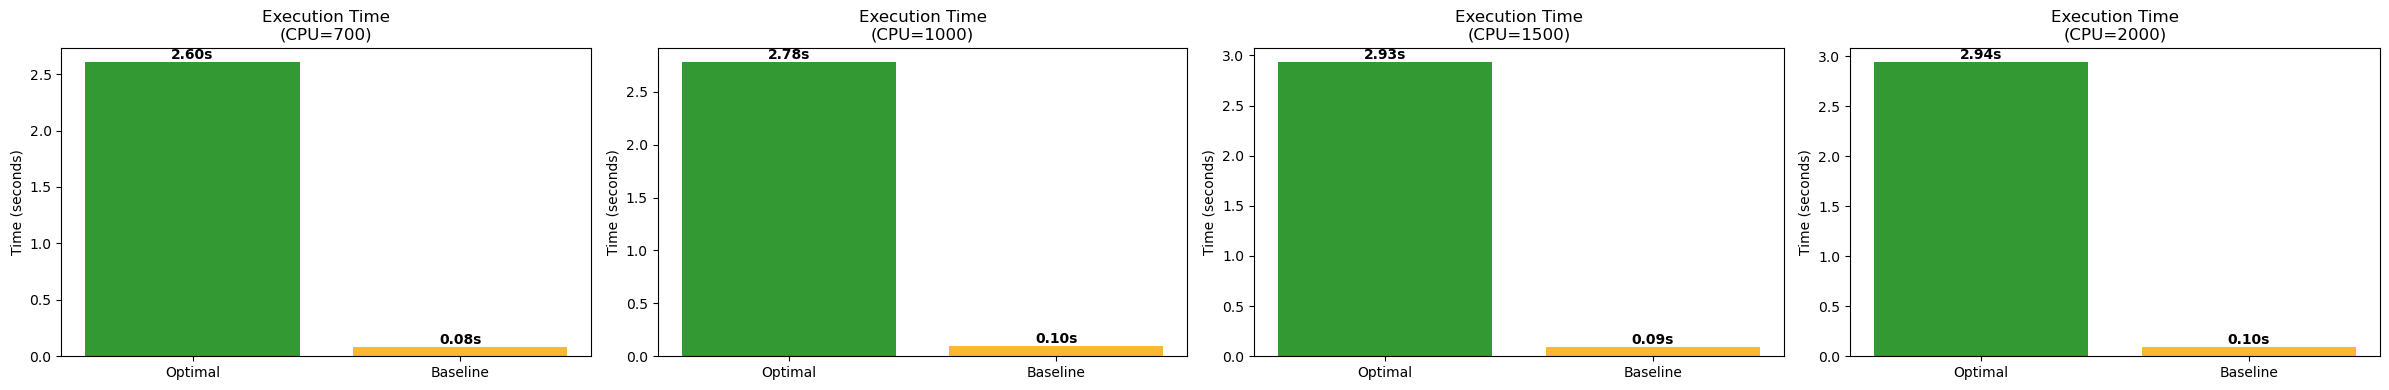

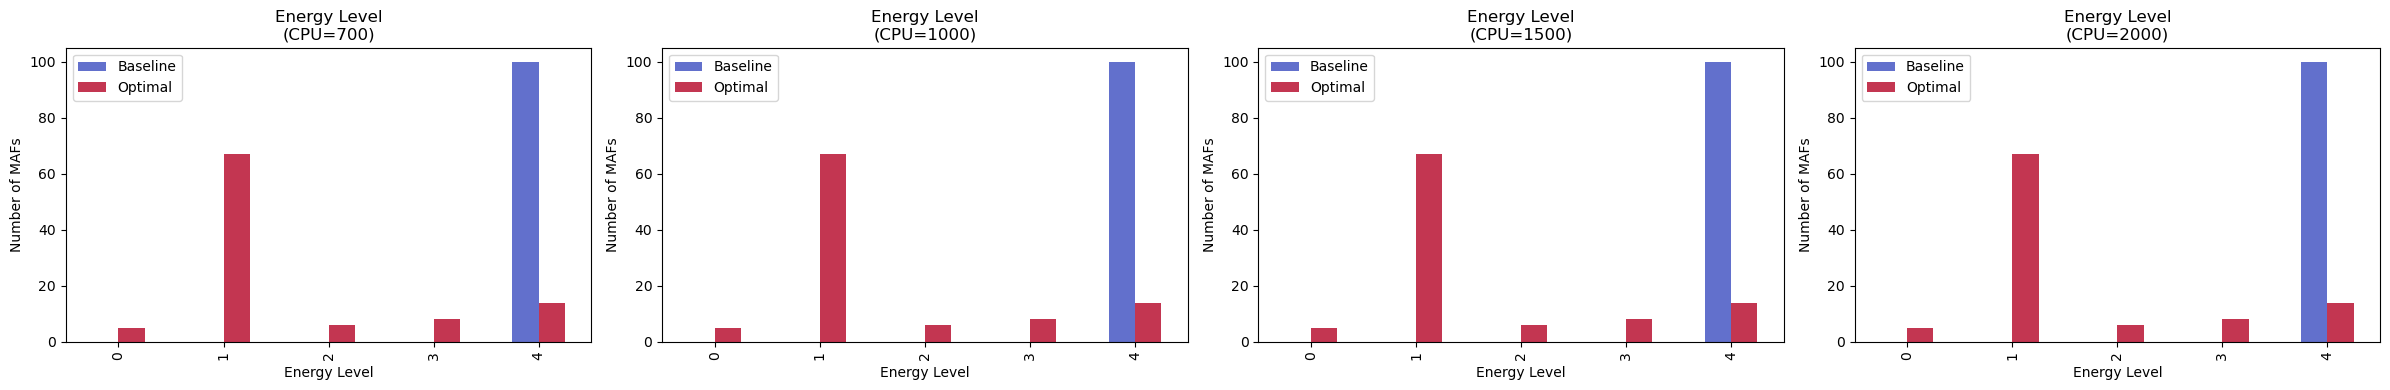

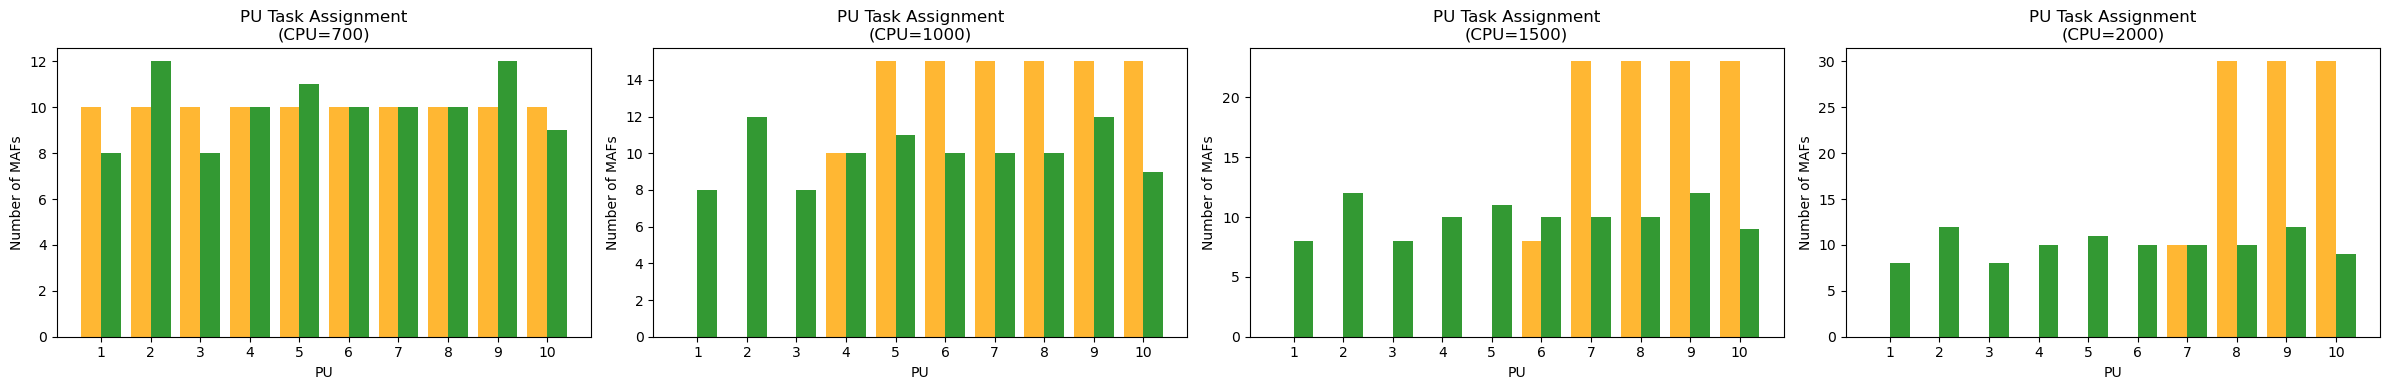

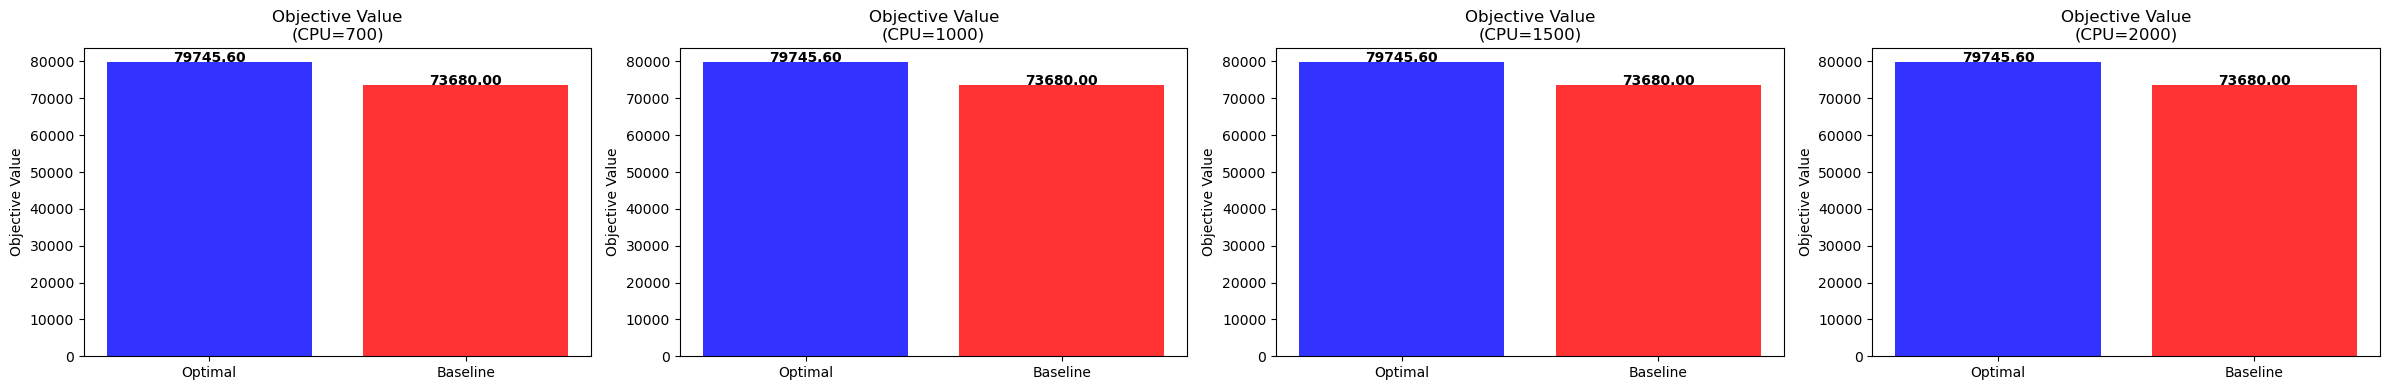

In [2]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 10  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [1000] * m  # Maximum energy consumption per processing unit
CPU_capacity = [1500] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 10000  # Total system resource capacity
P_idle = [2] * m  # Idle power consumption per PU
T_total = 300  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption
# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [150] * num_chains 


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")

    for k in range(num_chains):
        chain = chain_tasks[k]
        
        # Task chain `k` failure logic: if any `delta[i] = 0` within `chain_tasks[k]`, then `z_chain_k[k] = 0`.
        for i in chain:
            model.addConstr(z_chain_k[k] <= delta[i], name=f"ChainActivation_{k}_Task_{i}")

        #  Calculation of end-to-end delay in the task chain (execution time + communication delay)
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) for i in chain)
        communication_delay =  len(chain) - 1  

        #  End-to-end (E2E) delay constraints (effective only if `z_chain_k[k] = 1`)
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # mafs constraints
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i])

    # Limiting PU resources (corrected version)
    for j in range(m):
        execution_time = quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        idle_time = T_total - execution_time  
        model.addConstr(U_j[j] == execution_time / T_total)
        model.addConstr(E_PU[j] == P_idle[j]*idle_time + (P_max[j]-P_idle[j])*U_j[j]*T_total)
        model.addConstr(E_PU[j] <= E_PU_max[j])


    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    # Baseline only modifies the energy level selection logic, other constraints are consistent with Optimal.
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    return model if model.status == GRB.OPTIMAL else None


# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  
       
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  
    
    return maf_energy_levels, maf_pu_assignments


optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)



# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 




results = []
CPU_capacity_list = [[700]*m, [1000]*m, [1500]*m, [2000]*m]

fig_time, axes_time = plt.subplots(1, len(CPU_capacity_list), figsize=(24, 4))
fig_energy, axes_energy = plt.subplots(1, len(CPU_capacity_list), figsize=(24, 4))
fig_pu, axes_pu = plt.subplots(1, len(CPU_capacity_list), figsize=(24, 4))
fig_obj, axes_obj = plt.subplots(1, len(CPU_capacity_list), figsize=(24, 4))

for idx, CPU_capacity_test in enumerate(CPU_capacity_list):
    CPU_capacity = CPU_capacity_test
    
    # Optimal模型运行计时
    start_time_opt = time.perf_counter()
    optimal_model = run_gurobi_model(1000, 4, 1, baseline=False)
    execution_time_opt = time.perf_counter() - start_time_opt

    # Baseline模型运行计时
    start_time_base = time.perf_counter()
    baseline_model = run_gurobi_model(1000, 4, 1, baseline=True)
    execution_time_base = time.perf_counter() - start_time_base
    
    acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
    acceptance_rate_base = calculate_acceptance_rate(baseline_model)

    optimal_obj = optimal_model.objVal if optimal_model else None
    baseline_obj = baseline_model.objVal if baseline_model else None

    optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
    baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

    results.append({
        'CPU_capacity': CPU_capacity[0],
        'Optimal_Obj': optimal_obj,
        'Baseline_Obj': baseline_obj,
        'Optimal_Time': execution_time_opt,
        'Baseline_Time': execution_time_base,
        'Optimal_Acceptance': calculate_acceptance_rate(optimal_model),
        'Baseline_Acceptance': calculate_acceptance_rate(baseline_model),
    })

    # === 执行时间可视化 ===
    axes_time[idx].bar(["Optimal", "Baseline"], [execution_time_opt, execution_time_base], color=["green", "orange"], alpha=0.8)
    axes_time[idx].set_title(f"Execution Time\n(CPU={CPU_capacity[0]})")
    axes_time[idx].set_ylabel('Time (seconds)')
    for i, v in enumerate([execution_time_opt, execution_time_base]):
        axes_time[idx].text(i, v, f'{v:.2f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # === MAF 能耗等级分布可视化 ===
    df_energy = pd.DataFrame({
        "Baseline": np.bincount(baseline_energy_levels, minlength=K + 1)[1:],
        "Optimal": np.bincount(optimal_energy_levels, minlength=K + 1)[1:]
    })
    df_energy.plot(kind="bar", ax=axes_energy[idx], colormap="coolwarm", alpha=0.8)
    axes_energy[idx].set_title(f"Energy Level\n(CPU={CPU_capacity[0]})")
    axes_energy[idx].set_xlabel("Energy Level")
    axes_energy[idx].set_ylabel("Number of MAFs")

    # === PU 分配任务数量可视化 ===
    df_pu = pd.DataFrame({
        "Baseline": np.bincount(baseline_pu_assignments, minlength=m + 1)[1:],
        "Optimal": np.bincount(optimal_pu_assignments, minlength=m + 1)[1:]
    })
    bar_width = 0.4
    x = np.arange(1, m + 1)
    axes_pu[idx].bar(x - bar_width/2, df_pu["Baseline"], width=bar_width, color="orange", label="Baseline", alpha=0.8)
    axes_pu[idx].bar(x + bar_width/2, df_pu["Optimal"], width=bar_width, color="green", label="Optimal", alpha=0.8)
    axes_pu[idx].set_title(f"PU Task Assignment\n(CPU={CPU_capacity[0]})")
    axes_pu[idx].set_xlabel("PU")
    axes_pu[idx].set_ylabel("Number of MAFs")
    axes_pu[idx].set_xticks(np.arange(1, m + 1))

    # === 目标函数对比可视化 ===
    axes_obj[idx].bar(["Optimal", "Baseline"], [optimal_obj, baseline_obj], color=["blue", "red"], alpha=0.8)
    axes_obj[idx].set_title(f"Objective Value\n(CPU={CPU_capacity[0]})")
    axes_obj[idx].set_ylabel("Objective Value")
    for i, v in enumerate([optimal_obj, baseline_obj]):
        axes_obj[idx].text(i, v, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")

fig_time.tight_layout()
fig_energy.tight_layout()
fig_pu.tight_layout()
fig_obj.tight_layout()
plt.show()








Set parameter Username
Set parameter LicenseID to value 2599825
Academic license - for non-commercial use only - expires 2025-12-16


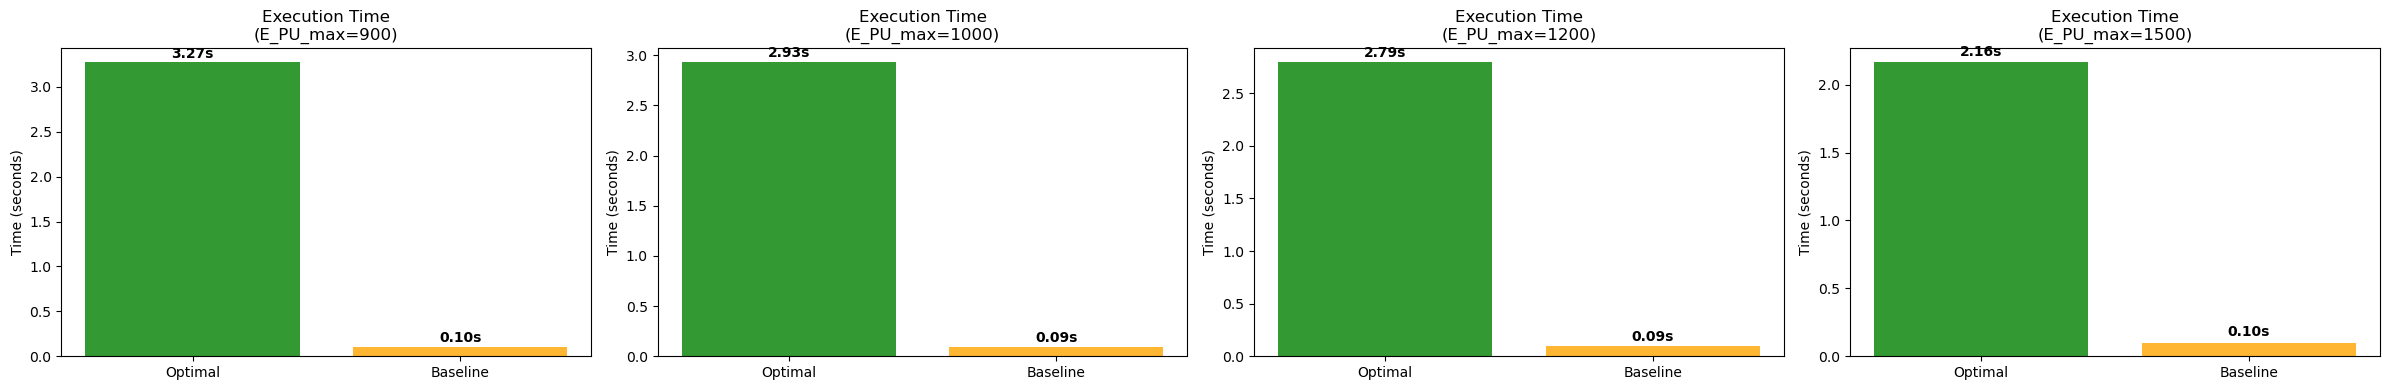

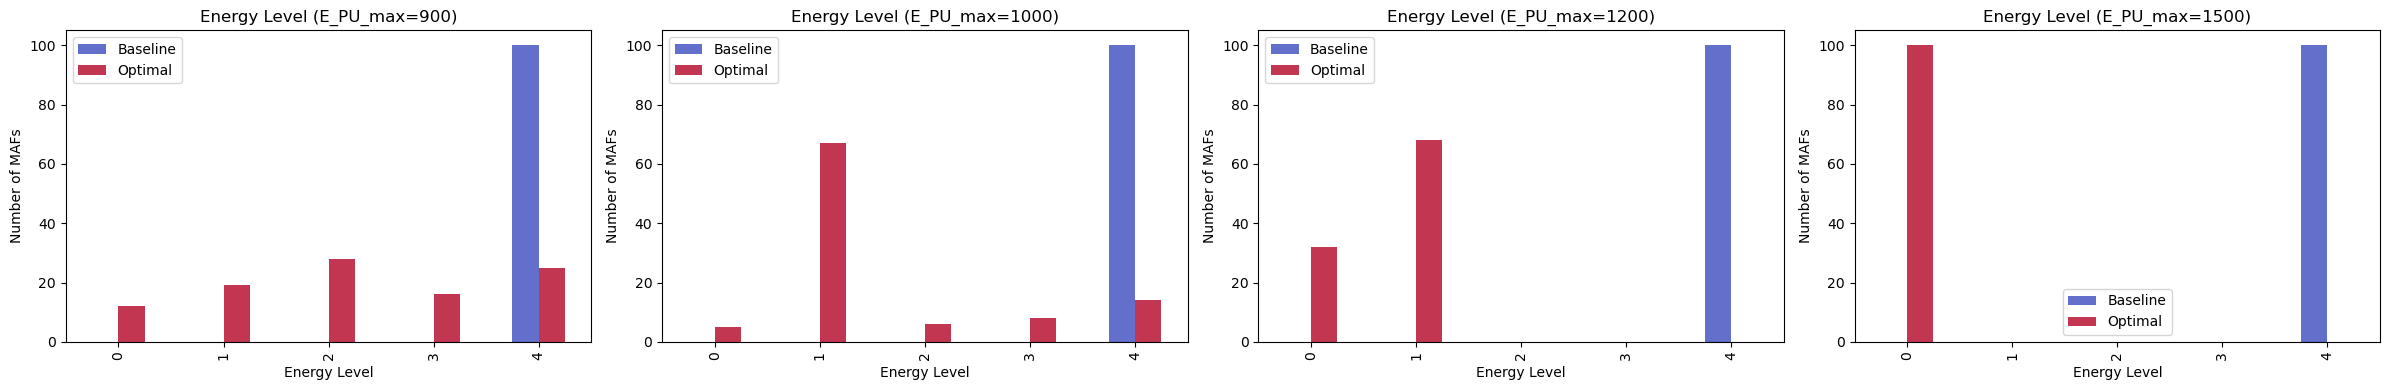

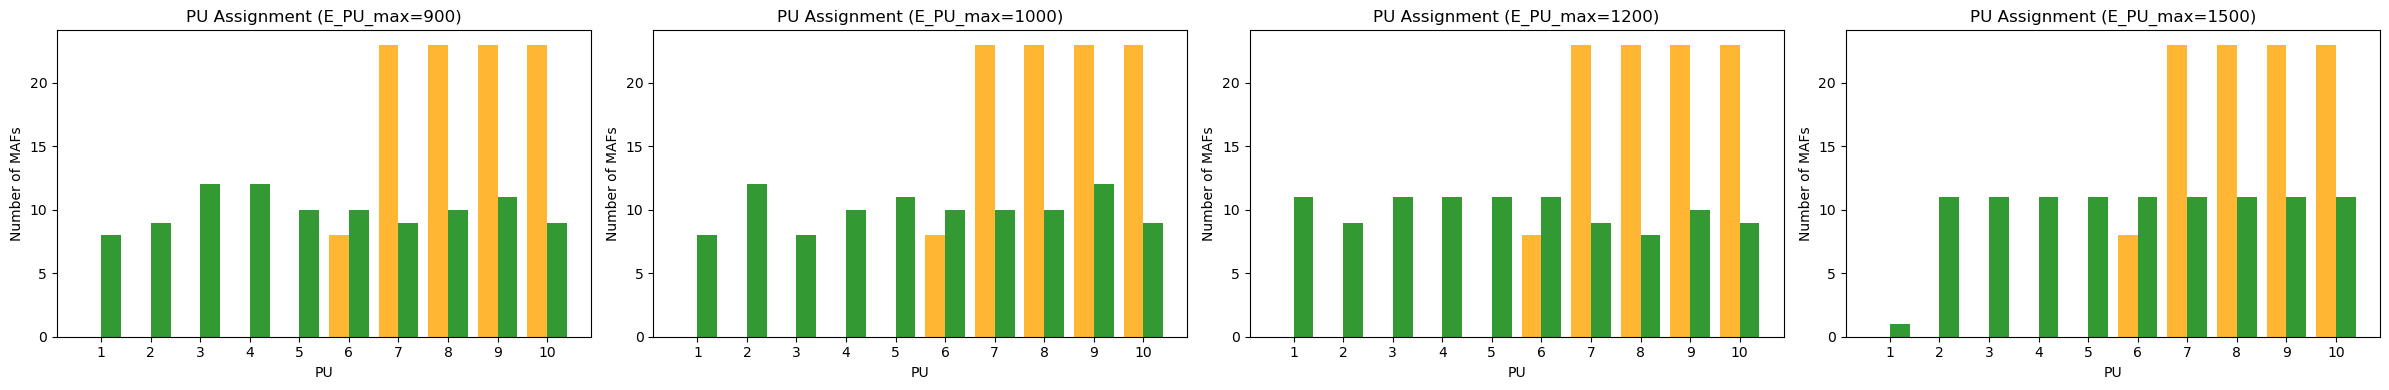

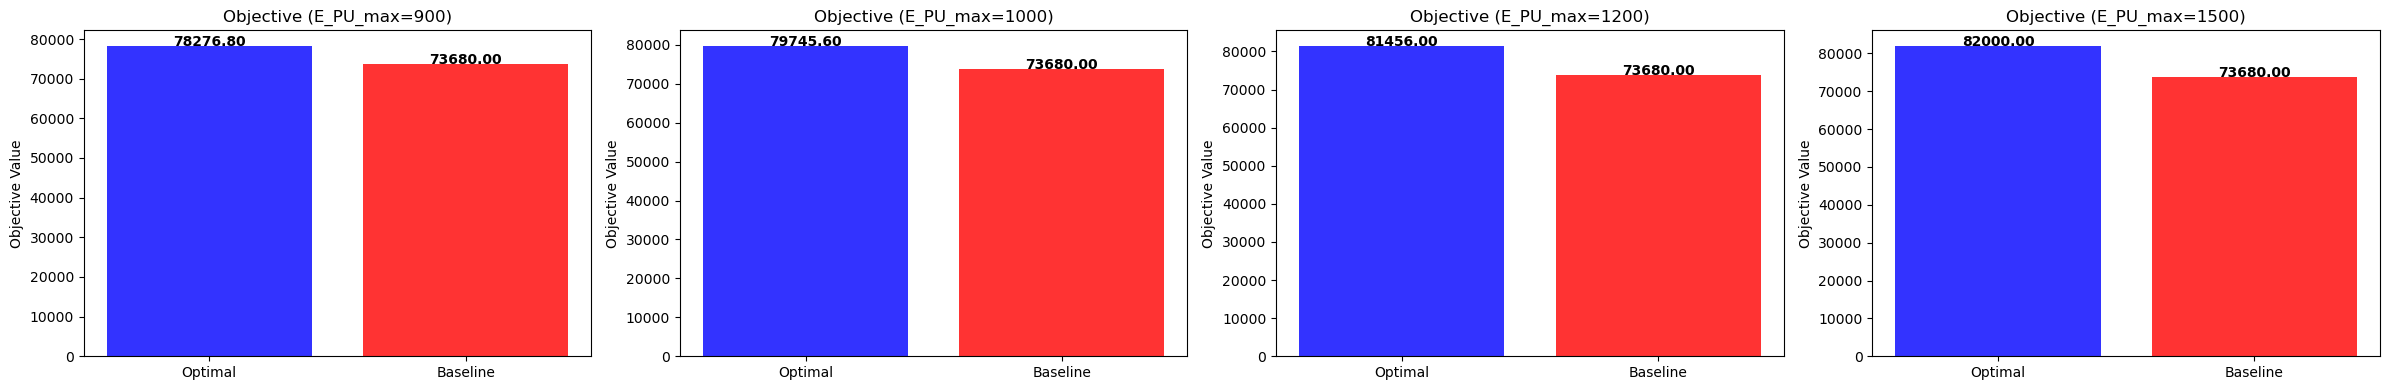

In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 10  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [1000] * m  # Maximum energy consumption per processing unit
CPU_capacity = [1500] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 10000  # Total system resource capacity
P_idle = [2] * m  # Idle power consumption per PU
T_total = 300  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption
# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [150] * num_chains 


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")

    for k in range(num_chains):
        chain = chain_tasks[k]
        
        # Task chain `k` failure logic: if any `delta[i] = 0` within `chain_tasks[k]`, then `z_chain_k[k] = 0`.
        for i in chain:
            model.addConstr(z_chain_k[k] <= delta[i], name=f"ChainActivation_{k}_Task_{i}")

        #  Calculation of end-to-end delay in the task chain (execution time + communication delay)
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) for i in chain)
        communication_delay =  len(chain) - 1  

        #  End-to-end (E2E) delay constraints (effective only if `z_chain_k[k] = 1`)
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # mafs constraints
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i])

    # Limiting PU resources (corrected version)
    for j in range(m):
        execution_time = quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        idle_time = T_total - execution_time  
        model.addConstr(U_j[j] == execution_time / T_total)
        model.addConstr(E_PU[j] == P_idle[j]*idle_time + (P_max[j]-P_idle[j])*U_j[j]*T_total)
        model.addConstr(E_PU[j] <= E_PU_max[j])


    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    # Baseline only modifies the energy level selection logic, other constraints are consistent with Optimal.
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    return model if model.status == GRB.OPTIMAL else None


# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  
       
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  
    
    return maf_energy_levels, maf_pu_assignments


optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)



# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 

E_PU_max_list = [[900]*m, [1000]*m, [1200]*m, [1500]*m]

results = []

fig_time, axes_time = plt.subplots(1, len(E_PU_max_list), figsize=(24, 4))
fig_energy, axes_energy = plt.subplots(1, len(E_PU_max_list), figsize=(24, 4))
fig_pu, axes_pu = plt.subplots(1, len(E_PU_max_list), figsize=(24, 4))
fig_obj, axes_obj = plt.subplots(1, len(E_PU_max_list), figsize=(24, 4))

for idx, E_PU_max_test in enumerate(E_PU_max_list):
    E_PU_max = E_PU_max_test
    
    start_time_opt = time.perf_counter()
    optimal_model = run_gurobi_model(1000, 4, 1, baseline=False)
    execution_time_opt = time.perf_counter() - start_time_opt

    start_time_base = time.perf_counter()
    baseline_model = run_gurobi_model(1000, 4, 1, baseline=True)
    execution_time_base = time.perf_counter() - start_time_base
    
    acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
    acceptance_rate_base = calculate_acceptance_rate(baseline_model)

    optimal_obj = optimal_model.objVal if optimal_model else None
    baseline_obj = baseline_model.objVal if baseline_model else None

    optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
    baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

    results.append({
        'E_PU_max': E_PU_max[0],
        'Optimal_Obj': optimal_obj,
        'Baseline_Obj': baseline_obj,
        'Optimal_Time': execution_time_opt,
        'Baseline_Time': execution_time_base,
        'Optimal_Acceptance': acceptance_rate_opt,
        'Baseline_Acceptance': acceptance_rate_base,
    })

    # === 执行时间可视化 ===
    axes_time[idx].bar(["Optimal", "Baseline"], [execution_time_opt, execution_time_base], color=["green", "orange"], alpha=0.8)
    axes_time[idx].set_title(f"Execution Time\n(E_PU_max={E_PU_max[0]})")
    axes_time[idx].set_ylabel('Time (seconds)')
    for i, v in enumerate([execution_time_opt, execution_time_base]):
        axes_time[idx].text(i, v + 0.05, f'{v:.2f}s', ha='center', fontsize=10, fontweight='bold')

    # 提取详细数据
    optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
    baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

    # === MAF 能耗等级分布 ===
    df_energy = pd.DataFrame({
        "Baseline": np.bincount(baseline_energy_levels, minlength=K + 1)[1:],
        "Optimal": np.bincount(optimal_energy_levels, minlength=K + 1)[1:]
    })
    df_energy.plot(kind="bar", ax=axes_energy[idx], colormap="coolwarm", alpha=0.8)
    axes_energy[idx].set_title(f"Energy Level (E_PU_max={E_PU_max[0]})")
    axes_energy[idx].set_xlabel("Energy Level")
    axes_energy[idx].set_ylabel("Number of MAFs")

    # === PU 任务分配 ===
    df_pu = pd.DataFrame({
        "Baseline": np.bincount(baseline_pu_assignments, minlength=m + 1)[1:].astype(int),
        "Optimal": np.bincount(optimal_pu_assignments, minlength=m + 1)[1:].astype(int)
    })
    bar_width = 0.4
    x = np.arange(1, m + 1)
    axes_pu[idx].bar(x - bar_width/2, df_pu["Baseline"], width=bar_width, color="orange", alpha=0.8)
    axes_pu[idx].bar(x + bar_width/2, df_pu["Optimal"], width=bar_width, color="green", alpha=0.8)
    axes_pu[idx].set_title(f"PU Assignment (E_PU_max={E_PU_max[0]})")
    axes_pu[idx].set_xlabel("PU")
    axes_pu[idx].set_ylabel("Number of MAFs")
    axes_pu[idx].set_xticks(x)

    # === 目标函数对比 ===
    axes_obj[idx].bar(["Optimal", "Baseline"], [optimal_obj, baseline_obj], color=["blue", "red"], alpha=0.8)
    axes_obj[idx].set_title(f"Objective (E_PU_max={E_PU_max[0]})")
    axes_obj[idx].set_ylabel("Objective Value")
    for i, v in enumerate([optimal_obj, baseline_obj]):
        axes_obj[idx].text(i, v + 5, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")

fig_time.tight_layout()
fig_energy.tight_layout()
fig_pu.tight_layout()
fig_obj.tight_layout()
plt.show()



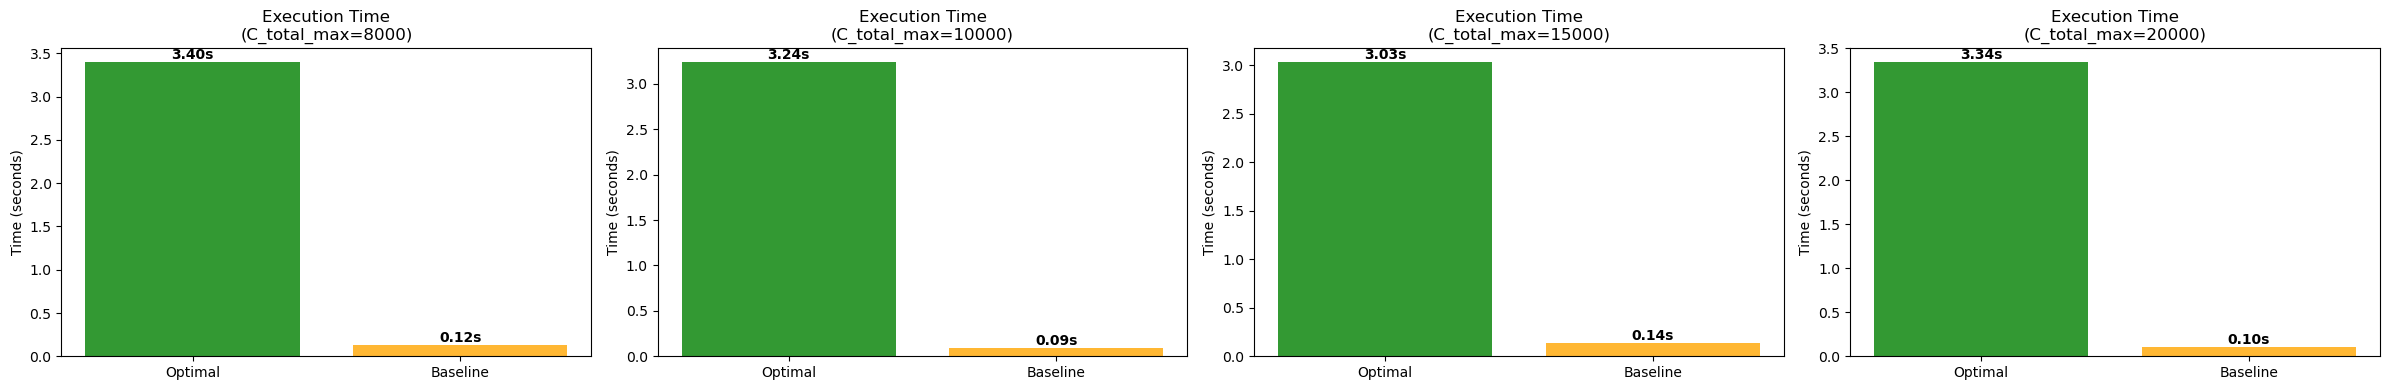

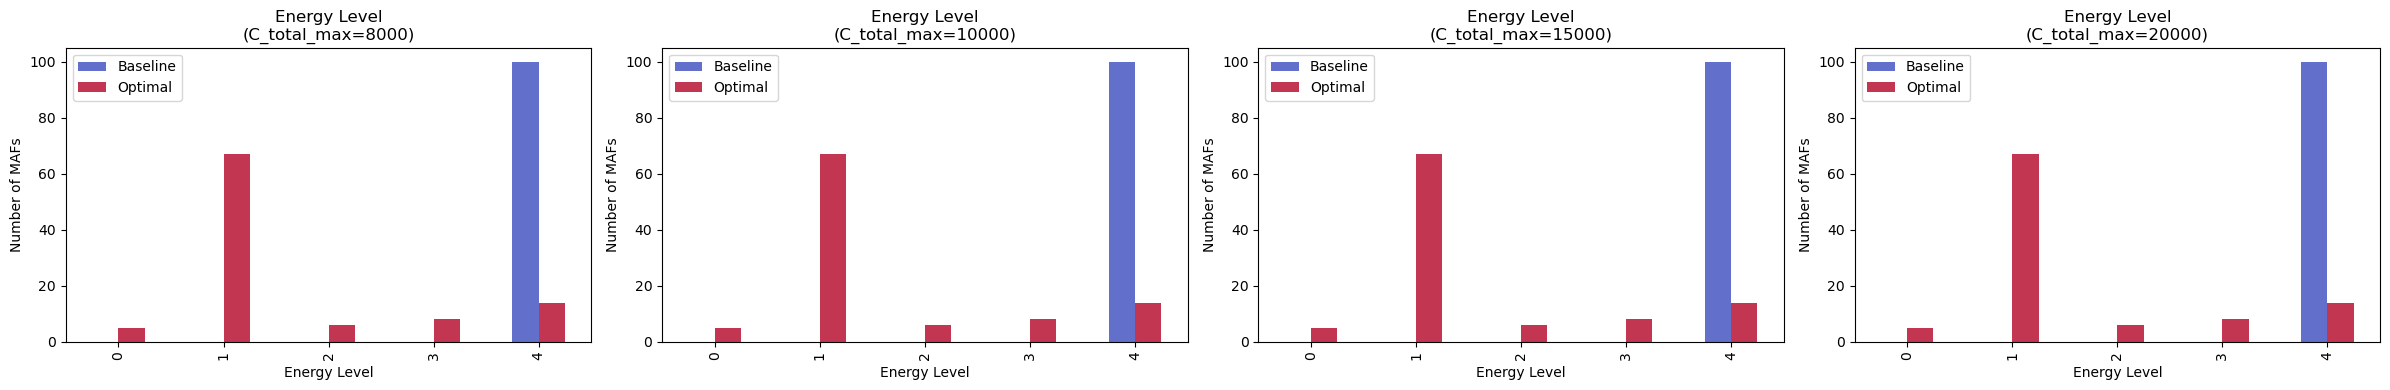

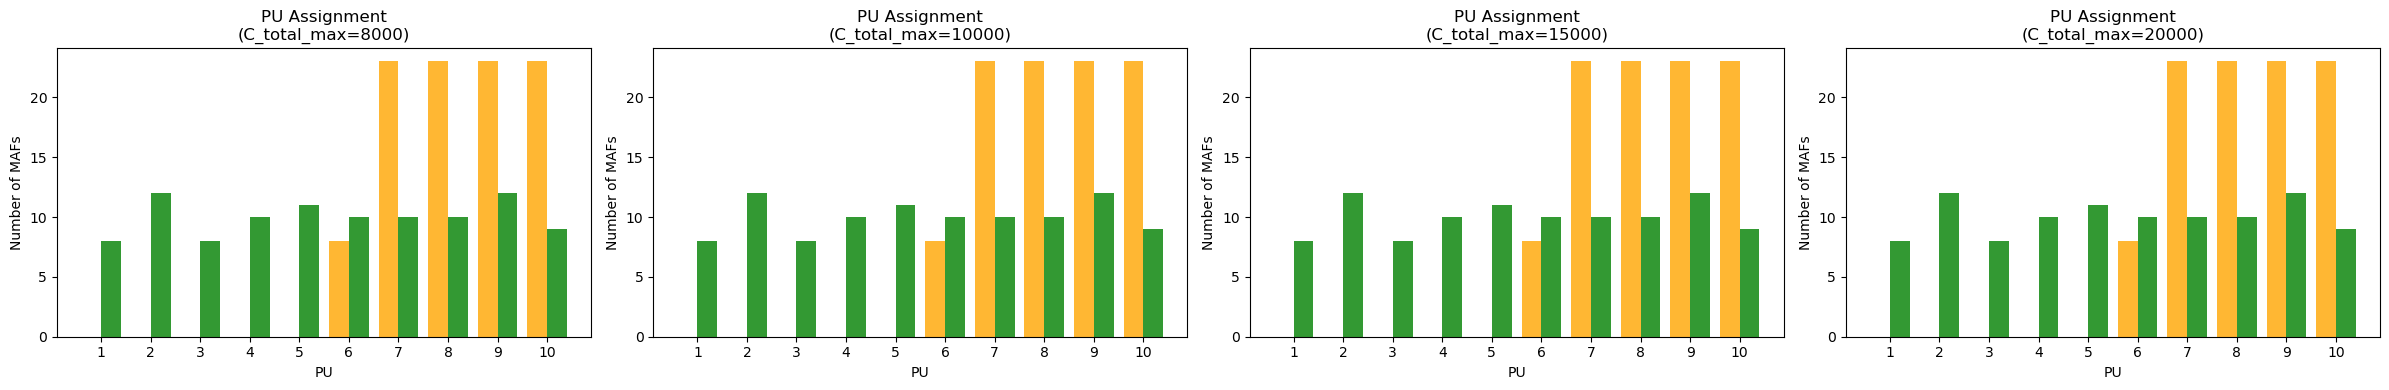

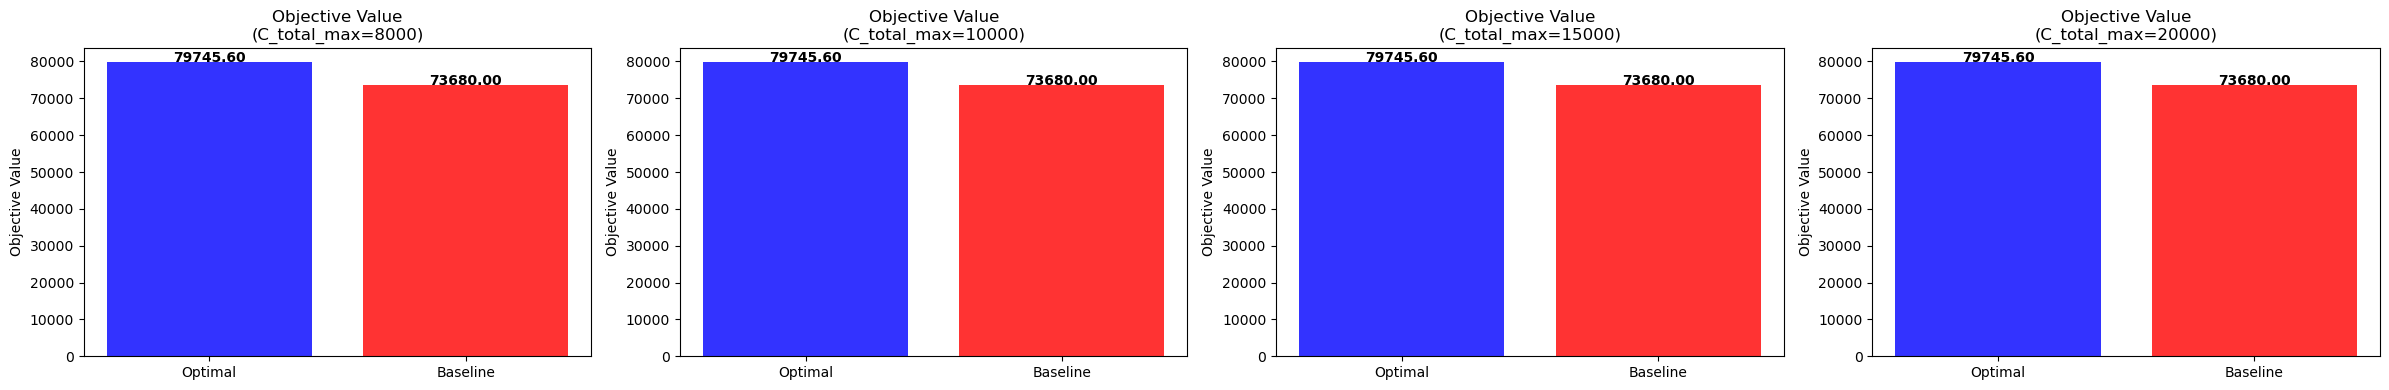

In [2]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 10  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [1000] * m  # Maximum energy consumption per processing unit
CPU_capacity = [1500] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 10000  # Total system resource capacity
P_idle = [2] * m  # Idle power consumption per PU
T_total = 300  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption
# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [150] * num_chains 


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")

    for k in range(num_chains):
        chain = chain_tasks[k]
        
        # Task chain `k` failure logic: if any `delta[i] = 0` within `chain_tasks[k]`, then `z_chain_k[k] = 0`.
        for i in chain:
            model.addConstr(z_chain_k[k] <= delta[i], name=f"ChainActivation_{k}_Task_{i}")

        #  Calculation of end-to-end delay in the task chain (execution time + communication delay)
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) for i in chain)
        communication_delay =  len(chain) - 1  

        #  End-to-end (E2E) delay constraints (effective only if `z_chain_k[k] = 1`)
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # mafs constraints
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i])

    # Limiting PU resources (corrected version)
    for j in range(m):
        execution_time = quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        idle_time = T_total - execution_time  
        model.addConstr(U_j[j] == execution_time / T_total)
        model.addConstr(E_PU[j] == P_idle[j]*idle_time + (P_max[j]-P_idle[j])*U_j[j]*T_total)
        model.addConstr(E_PU[j] <= E_PU_max[j])


    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    # Baseline only modifies the energy level selection logic, other constraints are consistent with Optimal.
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    return model if model.status == GRB.OPTIMAL else None


# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  
       
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  
    
    return maf_energy_levels, maf_pu_assignments


optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)



# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 


C_total_max_list = [8000, 10000, 15000, 20000]


results = []

fig_time, axes_time = plt.subplots(1, len(C_total_max_list), figsize=(24, 4))
fig_energy, axes_energy = plt.subplots(1, len(C_total_max_list), figsize=(24, 4))
fig_pu, axes_pu = plt.subplots(1, len(C_total_max_list), figsize=(24, 4))
fig_obj, axes_obj = plt.subplots(1, len(C_total_max_list), figsize=(24, 4))

for idx, C_total_max_test in enumerate(C_total_max_list):
    C_total_max = C_total_max_test
    
    start_time_opt = time.perf_counter()
    optimal_model = run_gurobi_model(1000, 4, 1, baseline=False)
    execution_time_opt = time.perf_counter() - start_time_opt

    start_time_base = time.perf_counter()
    baseline_model = run_gurobi_model(1000, 4, 1, baseline=True)
    execution_time_base = time.perf_counter() - start_time_base
    
    acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
    acceptance_rate_base = calculate_acceptance_rate(baseline_model)

    optimal_obj = optimal_model.objVal if optimal_model else None
    baseline_obj = baseline_model.objVal if baseline_model else None

    optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
    baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

    results.append({
        'C_total_max': C_total_max,
        'Optimal_Obj': optimal_obj,
        'Baseline_Obj': baseline_obj,
        'Optimal_Time': execution_time_opt,
        'Baseline_Time': execution_time_base,
        'Optimal_Acceptance': acceptance_rate_opt,
        'Baseline_Acceptance': acceptance_rate_base,
    })

    # === 执行时间可视化 ===
    axes_time[idx].bar(["Optimal", "Baseline"], [execution_time_opt, execution_time_base], color=["green", "orange"], alpha=0.8)
    axes_time[idx].set_title(f"Execution Time\n(C_total_max={C_total_max})")
    axes_time[idx].set_ylabel('Time (seconds)')
    for i, v in enumerate([execution_time_opt, execution_time_base]):
        axes_time[idx].text(i, v, f'{v:.2f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # === MAF 能耗等级分布 ===
    df_energy = pd.DataFrame({
        "Baseline": np.bincount(baseline_energy_levels, minlength=K + 1)[1:],
        "Optimal": np.bincount(optimal_energy_levels, minlength=K + 1)[1:]
    })
    df_energy.plot(kind="bar", ax=axes_energy[idx], colormap="coolwarm", alpha=0.8)
    axes_energy[idx].set_title(f"Energy Level\n(C_total_max={C_total_max})")
    axes_energy[idx].set_xlabel("Energy Level")
    axes_energy[idx].set_ylabel("Number of MAFs")

    # === PU任务分配 ===
    df_pu = pd.DataFrame({
        "Baseline": np.bincount(baseline_pu_assignments, minlength=m + 1)[1:].astype(int),
        "Optimal": np.bincount(optimal_pu_assignments, minlength=m + 1)[1:].astype(int)
    })
    bar_width = 0.4
    x = np.arange(1, m + 1)
    axes_pu[idx].bar(x - bar_width/2, df_pu["Baseline"], width=bar_width, color="orange", alpha=0.8)
    axes_pu[idx].bar(x + bar_width/2, df_pu["Optimal"], width=bar_width, color="green", alpha=0.8)
    axes_pu[idx].set_title(f"PU Assignment\n(C_total_max={C_total_max})")
    axes_pu[idx].set_xlabel("PU")
    axes_pu[idx].set_ylabel("Number of MAFs")
    axes_pu[idx].set_xticks(x)

    # === 目标函数对比 ===
    axes_obj[idx].bar(["Optimal", "Baseline"], [optimal_obj, baseline_obj], color=["blue", "red"], alpha=0.8)
    axes_obj[idx].set_title(f"Objective Value\n(C_total_max={C_total_max})")
    axes_obj[idx].set_ylabel("Objective Value")
    for i, v in enumerate([optimal_obj, baseline_obj]):
        axes_obj[idx].text(i, v, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")

fig_time.tight_layout()
fig_energy.tight_layout()
fig_pu.tight_layout()
fig_obj.tight_layout()
plt.show()




Set parameter Username
Set parameter LicenseID to value 2599825
Academic license - for non-commercial use only - expires 2025-12-16


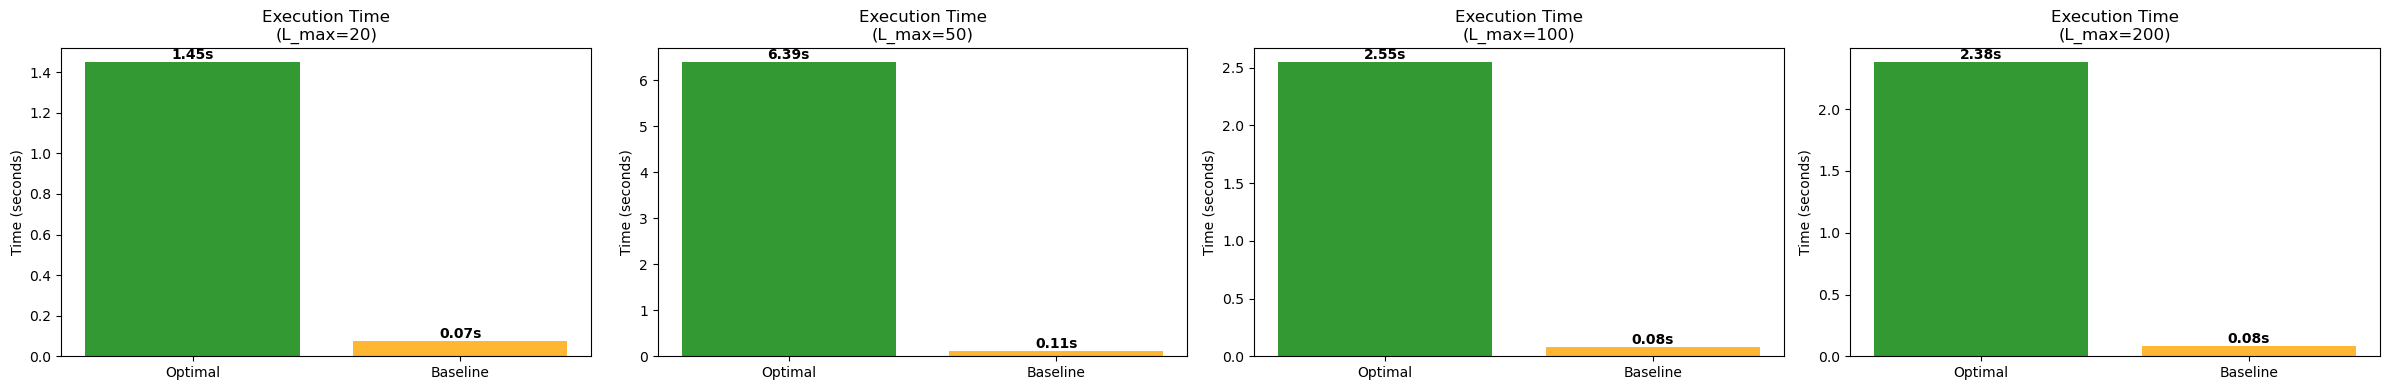

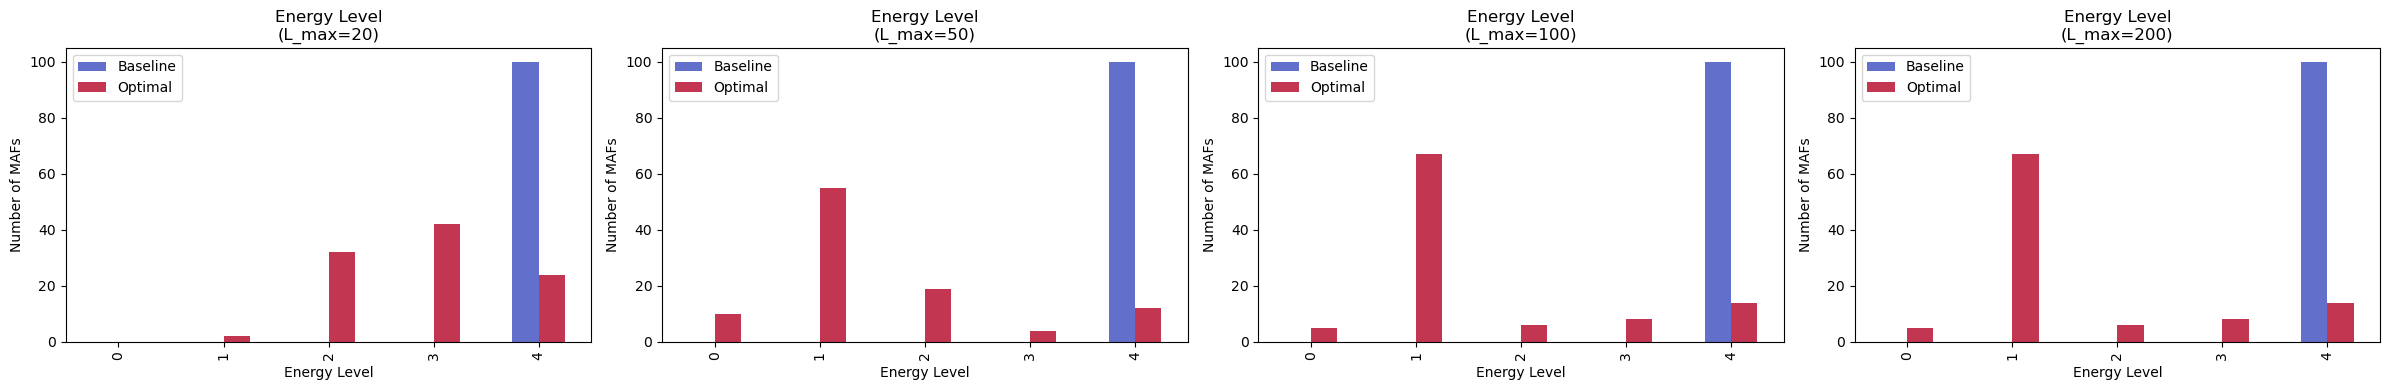

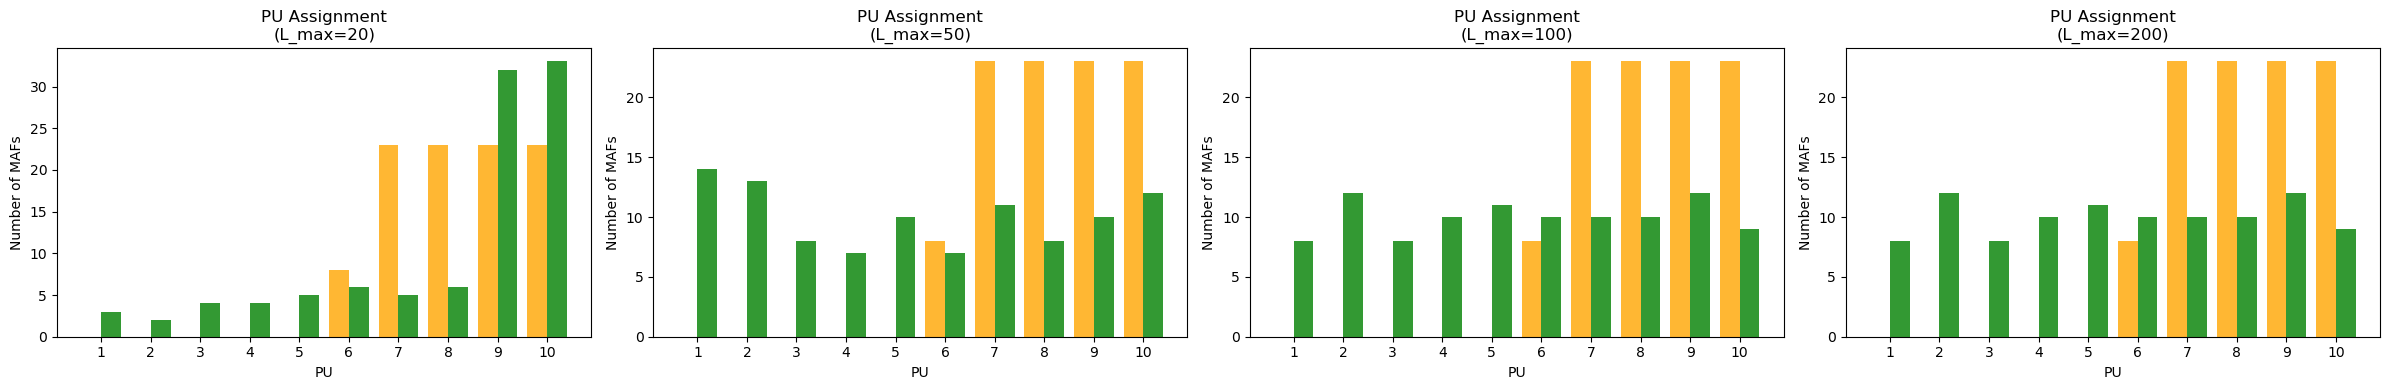

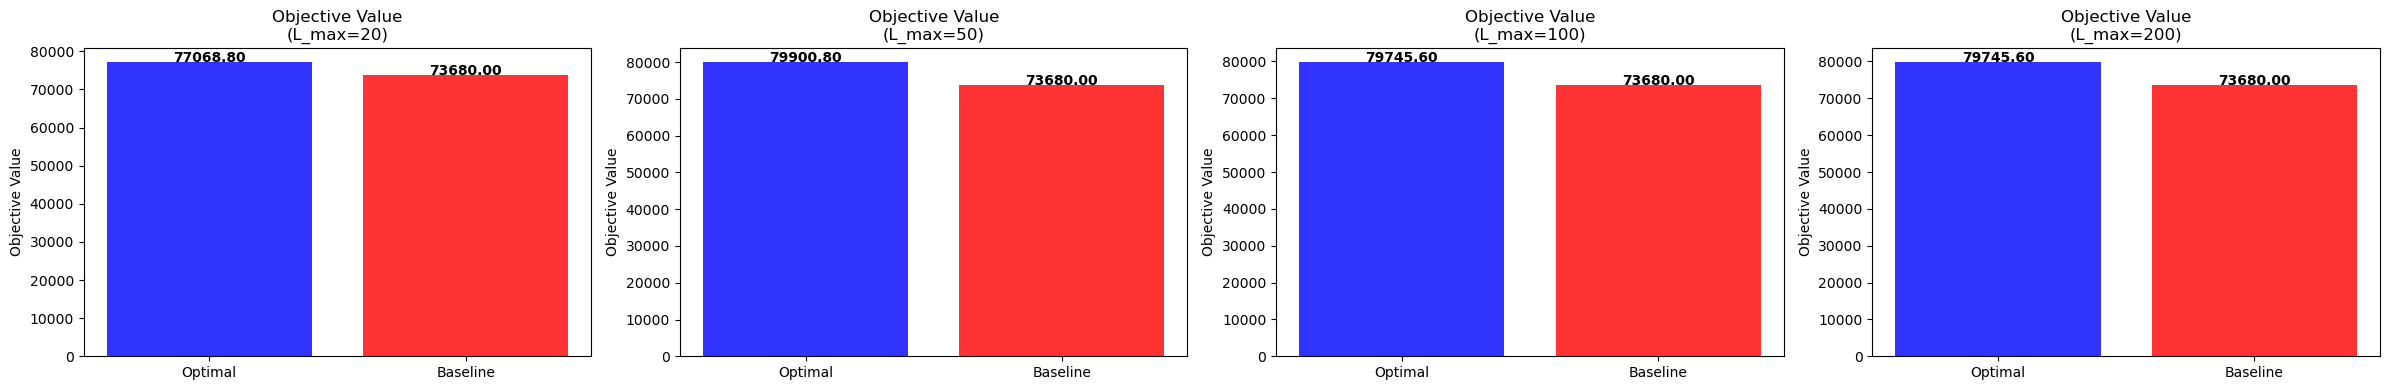

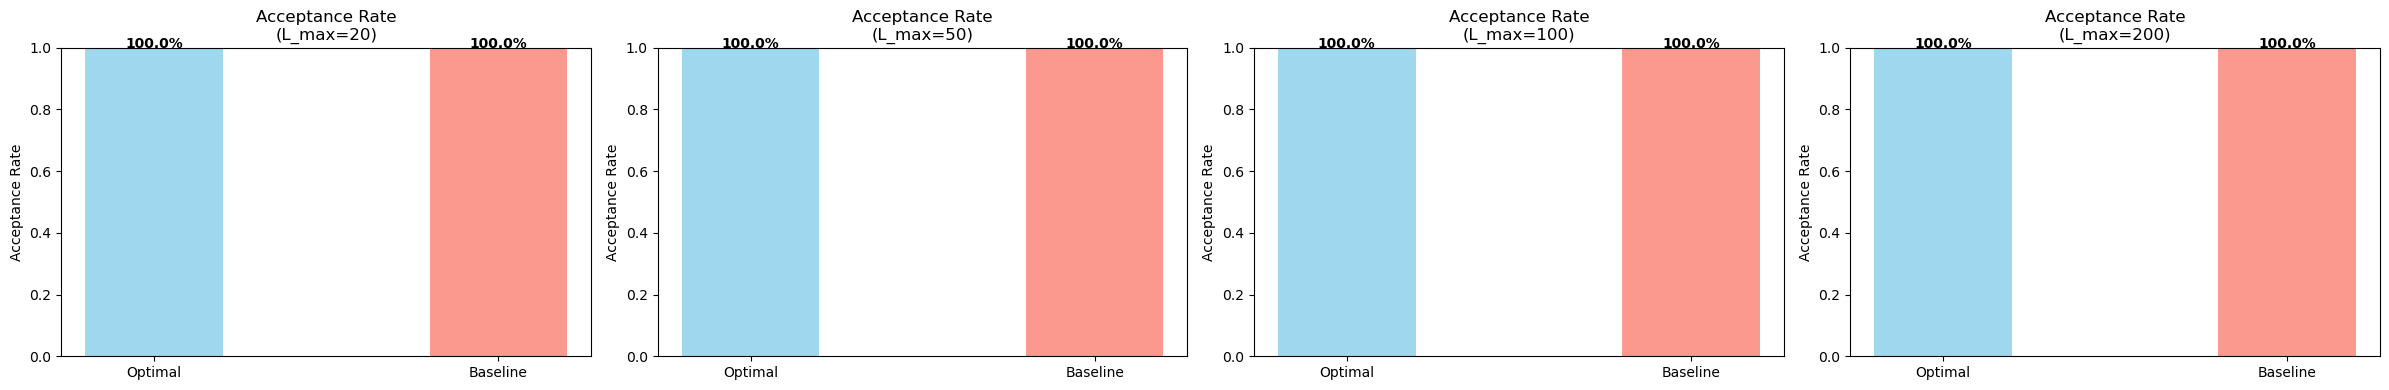

In [ ]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 10  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [1000] * m  # Maximum energy consumption per processing unit
CPU_capacity = [1500] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 10000  # Total system resource capacity
P_idle = [2] * m  # Idle power consumption per PU
T_total = 300  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption
# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [150] * num_chains 


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")

    for k in range(num_chains):
        chain = chain_tasks[k]
        
        # Task chain `k` failure logic: if any `delta[i] = 0` within `chain_tasks[k]`, then `z_chain_k[k] = 0`.
        for i in chain:
            model.addConstr(z_chain_k[k] <= delta[i], name=f"ChainActivation_{k}_Task_{i}")

        #  Calculation of end-to-end delay in the task chain (execution time + communication delay)
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) for i in chain)
        communication_delay =  len(chain) - 1  

        #  End-to-end (E2E) delay constraints (effective only if `z_chain_k[k] = 1`)
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # mafs constraints
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i])

    # Limiting PU resources (corrected version)
    for j in range(m):
        execution_time = quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        idle_time = T_total - execution_time  
        model.addConstr(U_j[j] == execution_time / T_total)
        model.addConstr(E_PU[j] == P_idle[j]*idle_time + (P_max[j]-P_idle[j])*U_j[j]*T_total)
        model.addConstr(E_PU[j] <= E_PU_max[j])


    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    # Baseline only modifies the energy level selection logic, other constraints are consistent with Optimal.
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    return model if model.status == GRB.OPTIMAL else None


# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  
       
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  
    
    return maf_energy_levels, maf_pu_assignments


optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)



# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 


L_max_list = [
    [20]*num_chains,
    [50]*num_chains,
    [100]*num_chains,
    [200]*num_chains
]

results = []

fig_time, axes_time = plt.subplots(1, len(L_max_list), figsize=(24, 4))
fig_energy, axes_energy = plt.subplots(1, len(L_max_list), figsize=(24, 4))
fig_pu, axes_pu = plt.subplots(1, len(L_max_list), figsize=(24, 4))
fig_obj, axes_obj = plt.subplots(1, len(L_max_list), figsize=(24, 4))
fig_accept, axes_accept = plt.subplots(1, len(L_max_list), figsize=(24, 4))

for idx, L_max_test in enumerate(L_max_list):
    L_max = L_max_test
    
    # Optimal模型运行计时
    start_time_opt = time.perf_counter()
    optimal_model = run_gurobi_model(1000, 4, 1, baseline=False)
    execution_time_opt = time.perf_counter() - start_time_opt

    # Baseline模型运行计时
    start_time_base = time.perf_counter()
    baseline_model = run_gurobi_model(1000, 4, 1, baseline=True)
    execution_time_base = time.perf_counter() - start_time_base
    
    # 提取目标值
    optimal_obj = optimal_model.objVal if optimal_model else None
    baseline_obj = baseline_model.objVal if baseline_model else None

    # 提取接受率
    acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
    acceptance_rate_base = calculate_acceptance_rate(baseline_model)

    # 提取任务结果
    optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
    baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

    results.append({
        'L_max': L_max[0],
        'Optimal_Obj': optimal_obj,
        'Baseline_Obj': baseline_obj,
        'Optimal_Time': execution_time_opt,
        'Baseline_Time': execution_time_base,
        'Optimal_Acceptance': acceptance_rate_opt,
        'Baseline_Acceptance': acceptance_rate_base,
    })

    # === 执行时间可视化 ===
    times = [execution_time_opt, execution_time_base]
    labels = ["Optimal", "Baseline"]
    colors = ["green", "orange"]
    
    axes_time[idx].bar(labels, times, color=colors, alpha=0.8)
    axes_time[idx].set_title(f"Execution Time\n(L_max={L_max[0]})")
    axes_time[idx].set_ylabel('Time (seconds)')
    for i, v in enumerate(times):
        axes_time[idx].text(i, v, f'{v:.2f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # 提取能耗级别和PU分配数据
    optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
    baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

    # === MAF能耗等级分布可视化 ===
    energy_levels = np.arange(1, K + 1)
    df_energy = pd.DataFrame({
        "Baseline": np.bincount(baseline_energy_levels, minlength=K + 1)[1:],
        "Optimal": np.bincount(optimal_energy_levels, minlength=K + 1)[1:]
    })
    df_energy.plot(kind="bar", ax=axes_energy[idx], colormap="coolwarm", alpha=0.8)
    axes_energy[idx].set_title(f"Energy Level\n(L_max={L_max[0]})")
    axes_energy[idx].set_xlabel("Energy Level")
    axes_energy[idx].set_ylabel("Number of MAFs")

    # === PU任务分配可视化 ===
    df_pu = pd.DataFrame({
        "Baseline": np.bincount(baseline_pu_assignments, minlength=m + 1)[1:].astype(int),
        "Optimal": np.bincount(optimal_pu_assignments, minlength=m + 1)[1:].astype(int)
    })
    bar_width = 0.4
    x = np.arange(1, m + 1)
    axes_pu[idx].bar(x - bar_width/2, df_pu["Baseline"], width=bar_width, color="orange", alpha=0.8)
    axes_pu[idx].bar(x + bar_width/2, df_pu["Optimal"], width=bar_width, color="green", alpha=0.8)
    axes_pu[idx].set_title(f"PU Assignment\n(L_max={L_max[0]})")
    axes_pu[idx].set_xlabel("PU")
    axes_pu[idx].set_ylabel("Number of MAFs")
    axes_pu[idx].set_xticks(x)

    # === 目标函数对比 ===
    axes_obj[idx].bar(labels, [optimal_obj, baseline_obj], color=["blue", "red"], alpha=0.8)
    axes_obj[idx].set_title(f"Objective Value\n(L_max={L_max[0]})")
    axes_obj[idx].set_ylabel("Objective Value")
    for i, v in enumerate([optimal_obj, baseline_obj]):
        axes_obj[idx].text(i, v, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")

    # === Acceptance Rate 对比 ===
    axes_accept[idx].bar(labels, [acceptance_rate_opt, acceptance_rate_base], color=["skyblue", "salmon"], alpha=0.8, width=0.4)
    axes_accept[idx].set_ylim(0, 1)
    axes_accept[idx].set_title(f"Acceptance Rate\n(L_max={L_max[0]})")
    axes_accept[idx].set_ylabel("Acceptance Rate")
    for i, v in enumerate([acceptance_rate_opt, acceptance_rate_base]):
        axes_accept[idx].text(i, v, f"{v:.1%}", ha='center', fontsize=10, fontweight='bold')

# 调整布局
fig_time.tight_layout()
fig_energy.tight_layout()
fig_pu.tight_layout()
fig_obj.tight_layout()
fig_accept.tight_layout()

plt.show()



Set parameter Username
Set parameter LicenseID to value 2597751
Academic license - for non-commercial use only - expires 2025-12-10


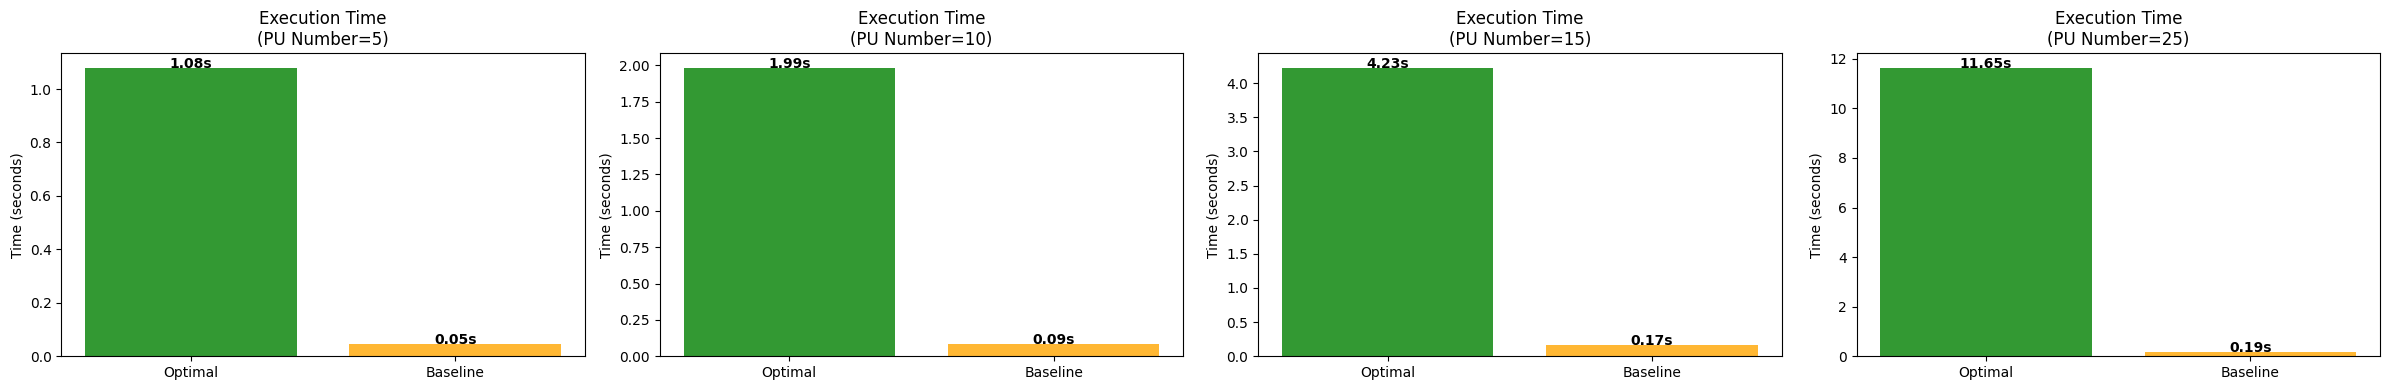

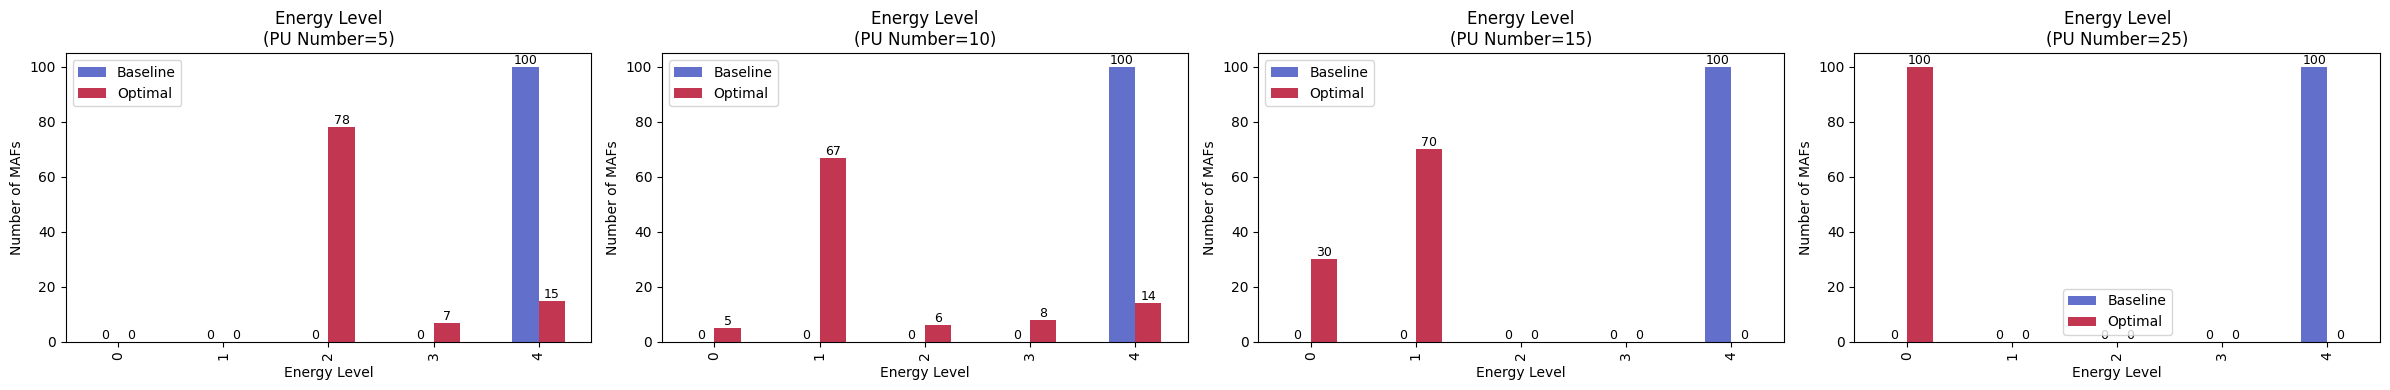

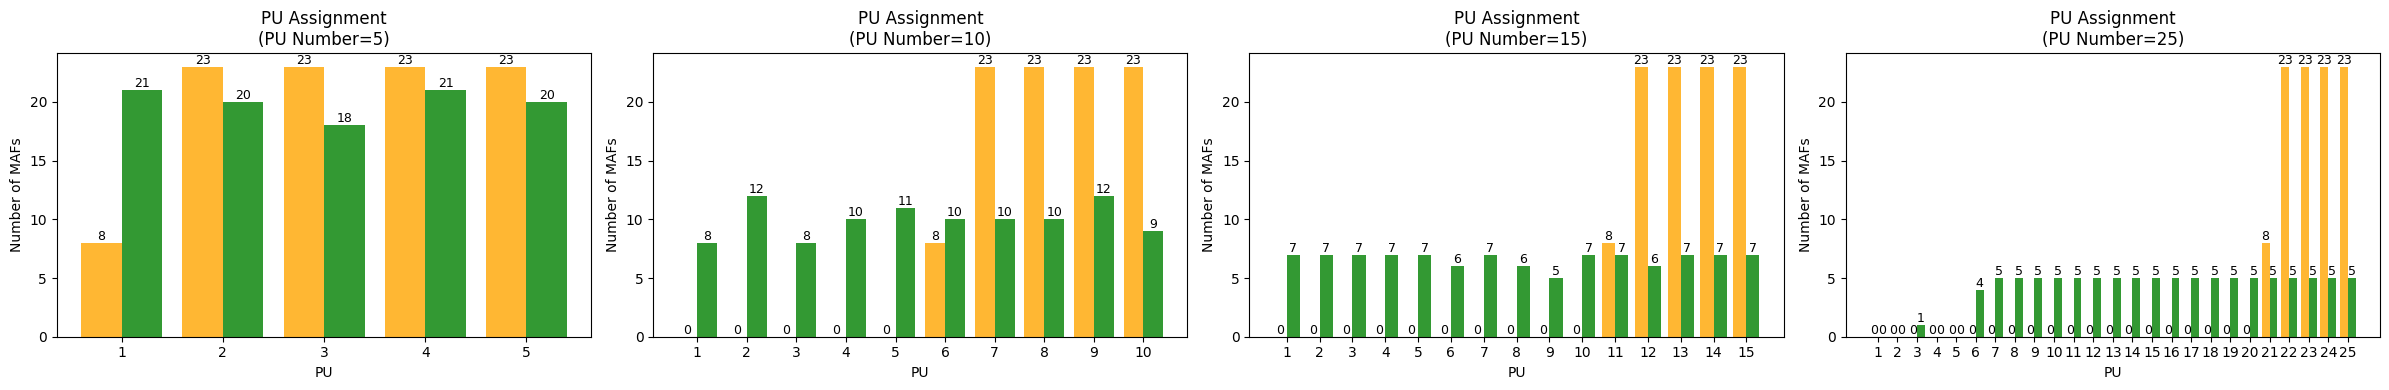

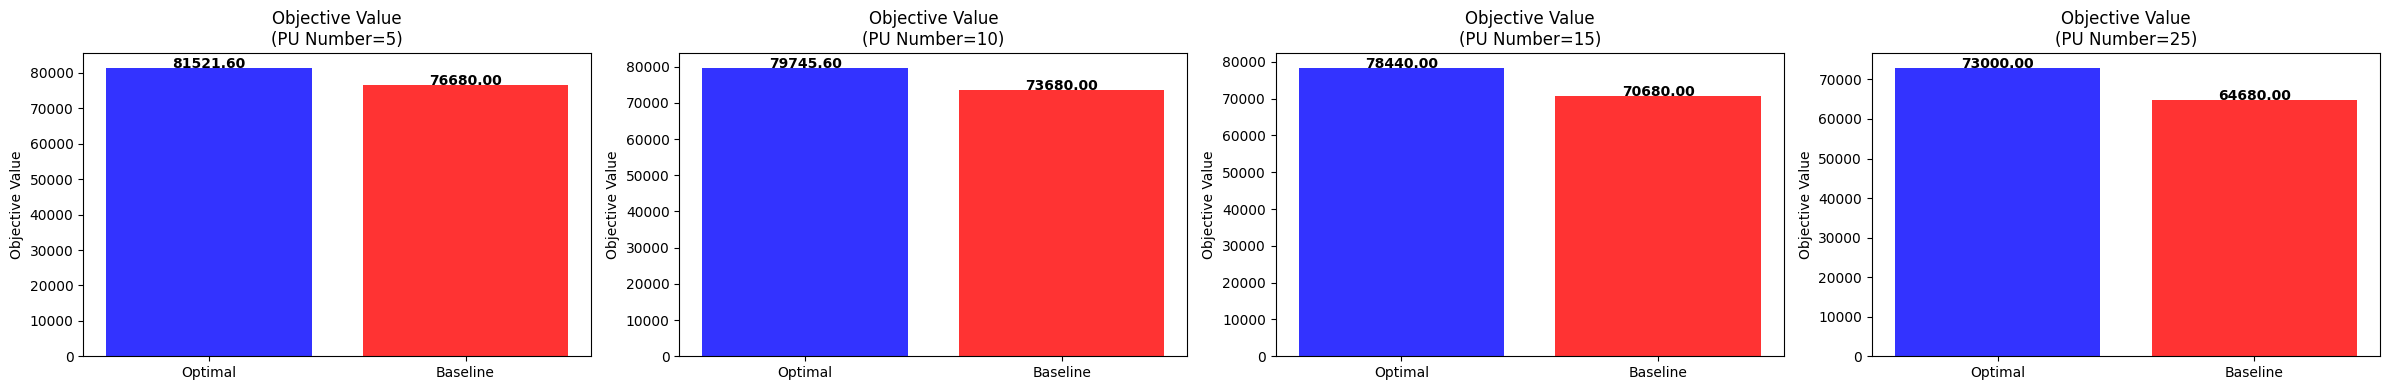

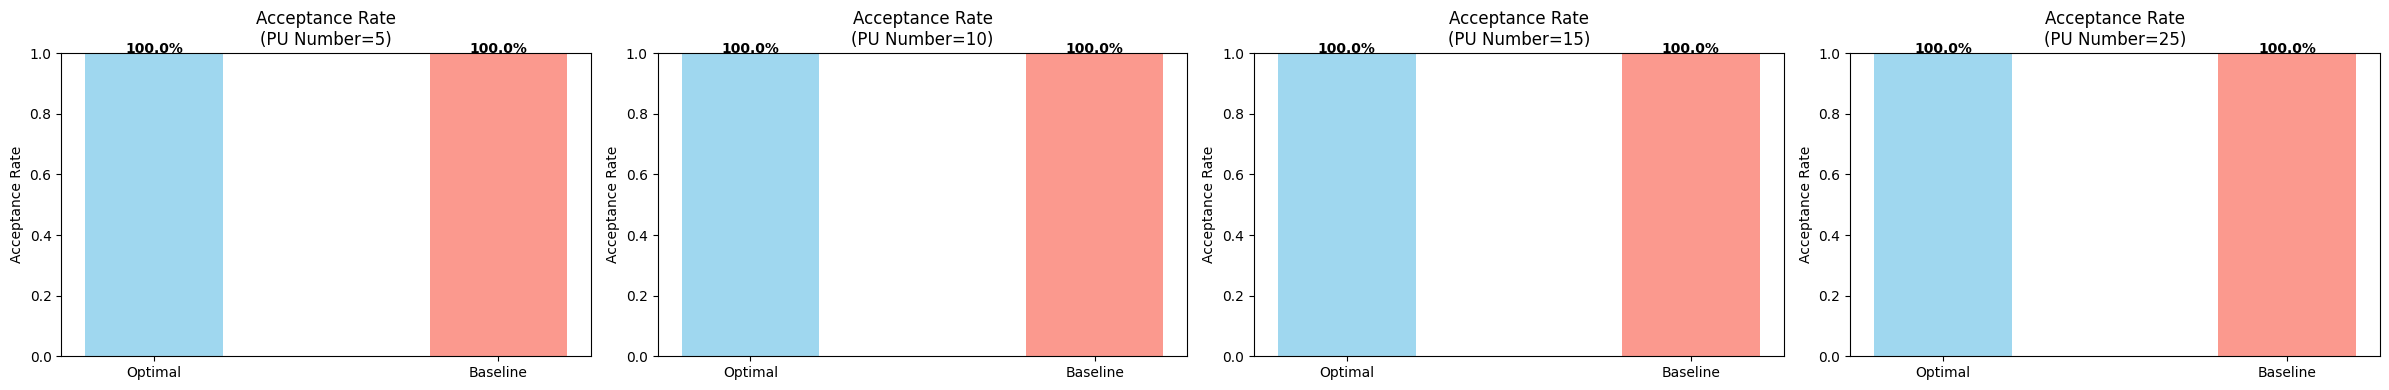

In [ ]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 10  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [1000] * m  # Maximum energy consumption per processing unit
CPU_capacity = [1500] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 10000  # Total system resource capacity
P_idle = [2] * m  # Idle power consumption per PU
T_total = 300  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption
# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [150] * num_chains 


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")

    for k in range(num_chains):
        chain = chain_tasks[k]
        
        # Task chain `k` failure logic: if any `delta[i] = 0` within `chain_tasks[k]`, then `z_chain_k[k] = 0`.
        for i in chain:
            model.addConstr(z_chain_k[k] <= delta[i], name=f"ChainActivation_{k}_Task_{i}")

        #  Calculation of end-to-end delay in the task chain (execution time + communication delay)
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) for i in chain)
        communication_delay =  len(chain) - 1  

        #  End-to-end (E2E) delay constraints (effective only if `z_chain_k[k] = 1`)
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # mafs constraints
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i])

    # Limiting PU resources (corrected version)
    for j in range(m):
        execution_time = quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        idle_time = T_total - execution_time  
        model.addConstr(U_j[j] == execution_time / T_total)
        model.addConstr(E_PU[j] == P_idle[j]*idle_time + (P_max[j]-P_idle[j])*U_j[j]*T_total)
        model.addConstr(E_PU[j] <= E_PU_max[j])


    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    # Baseline only modifies the energy level selection logic, other constraints are consistent with Optimal.
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    return model if model.status == GRB.OPTIMAL else None


# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  
       
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  
    
    return maf_energy_levels, maf_pu_assignments


optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)



# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 


PU_numbers = [5, 10, 15, 25]
test_param_list = PU_numbers
test_param_name = "PU Number"

results = []

fig_time, axes_time = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_energy, axes_energy = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_pu, axes_pu = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_obj, axes_obj = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_accept, axes_accept = plt.subplots(1, len(test_param_list), figsize=(24, 4))

for idx, param_value in enumerate(test_param_list):
    
    
    m = param_value  

   
    CPU_capacity = [1500] * m
    E_PU_max = [1000] * m
    P_idle = [2] * m
    P_max = [20] * m

    #  Optimal 
    start_time_opt = time.perf_counter()
    optimal_model = run_gurobi_model(1000, 4, 1, baseline=False)
    execution_time_opt = time.perf_counter() - start_time_opt

    #  Baseline 
    start_time_base = time.perf_counter()
    baseline_model = run_gurobi_model(1000, 4, 1, baseline=True)
    execution_time_base = time.perf_counter() - start_time_base


    optimal_obj = optimal_model.objVal if optimal_model else None
    baseline_obj = baseline_model.objVal if baseline_model else None

    acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
    acceptance_rate_base = calculate_acceptance_rate(baseline_model)

    optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
    baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

    results.append({
        test_param_name: param_value,
        'Optimal_Obj': optimal_obj,
        'Baseline_Obj': baseline_obj,
        'Optimal_Time': execution_time_opt,
        'Baseline_Time': execution_time_base,
        'Optimal_Acceptance': acceptance_rate_opt,
        'Baseline_Acceptance': acceptance_rate_base,
    })

    axes_time[idx].bar(["Optimal", "Baseline"], [execution_time_opt, execution_time_base],
                       color=["green", "orange"], alpha=0.8)
    axes_time[idx].set_title(f"Execution Time\n({test_param_name}={param_value})")
    axes_time[idx].set_ylabel('Time (seconds)')
    for i, v in enumerate([execution_time_opt, execution_time_base]):
        axes_time[idx].text(i, v, f'{v:.2f}s', ha='center', fontsize=10, fontweight='bold')

    
  
    df_energy = pd.DataFrame({
        "Baseline": np.bincount(baseline_energy_levels, minlength=K + 1)[1:],
        "Optimal": np.bincount(optimal_energy_levels, minlength=K + 1)[1:]
    })
    df_energy.plot(kind="bar", ax=axes_energy[idx], colormap="coolwarm", alpha=0.8)
    axes_energy[idx].set_title(f"Energy Level\n({test_param_name}={param_value})")
    axes_energy[idx].set_xlabel("Energy Level")
    axes_energy[idx].set_ylabel("Number of MAFs")


    for container in axes_energy[idx].containers:
        axes_energy[idx].bar_label(container, fontsize=9)


    # === PU Assignment ===
    max_pu_id = max(m, max(baseline_pu_assignments, default=0), max(optimal_pu_assignments, default=0))
    df_pu = pd.DataFrame({
        "Baseline": np.bincount(baseline_pu_assignments, minlength=max_pu_id + 1)[1:],
        "Optimal": np.bincount(optimal_pu_assignments, minlength=max_pu_id + 1)[1:]
    })
    bar_width = 0.4
    x = np.arange(1, max_pu_id + 1)

    bars_baseline = axes_pu[idx].bar(x - bar_width/2, df_pu["Baseline"], width=bar_width, color="orange", alpha=0.8, label="Baseline")
    bars_optimal = axes_pu[idx].bar(x + bar_width/2, df_pu["Optimal"], width=bar_width, color="green", alpha=0.8, label="Optimal")

    axes_pu[idx].set_title(f"PU Assignment\n({test_param_name}={param_value})")
    axes_pu[idx].set_xlabel("PU")
    axes_pu[idx].set_ylabel("Number of MAFs")
    axes_pu[idx].set_xticks(x)

    
    axes_pu[idx].bar_label(bars_baseline, fontsize=9)
    axes_pu[idx].bar_label(bars_optimal, fontsize=9)

    
    # === Objective Value ===
    axes_obj[idx].bar(["Optimal", "Baseline"], [optimal_obj, baseline_obj], color=["blue", "red"], alpha=0.8)
    axes_obj[idx].set_title(f"Objective Value\n({test_param_name}={param_value})")
    axes_obj[idx].set_ylabel("Objective Value")
    for i, v in enumerate([optimal_obj, baseline_obj]):
        axes_obj[idx].text(i, v, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")

    # === Acceptance Rate ===
    axes_accept[idx].bar(["Optimal", "Baseline"], [acceptance_rate_opt, acceptance_rate_base], color=["skyblue", "salmon"], alpha=0.8, width=0.4)
    axes_accept[idx].set_ylim(0, 1)
    axes_accept[idx].set_title(f"Acceptance Rate\n({test_param_name}={param_value})")
    axes_accept[idx].set_ylabel("Acceptance Rate")
    for i, v in enumerate([acceptance_rate_opt, acceptance_rate_base]):
        axes_accept[idx].text(i, v, f"{v:.1%}", ha='center', fontsize=10, fontweight='bold')


fig_time.tight_layout()
fig_energy.tight_layout()
fig_pu.tight_layout()
fig_obj.tight_layout()
fig_accept.tight_layout()

plt.show()









Set parameter Username
Set parameter LicenseID to value 2599825
Academic license - for non-commercial use only - expires 2025-12-16


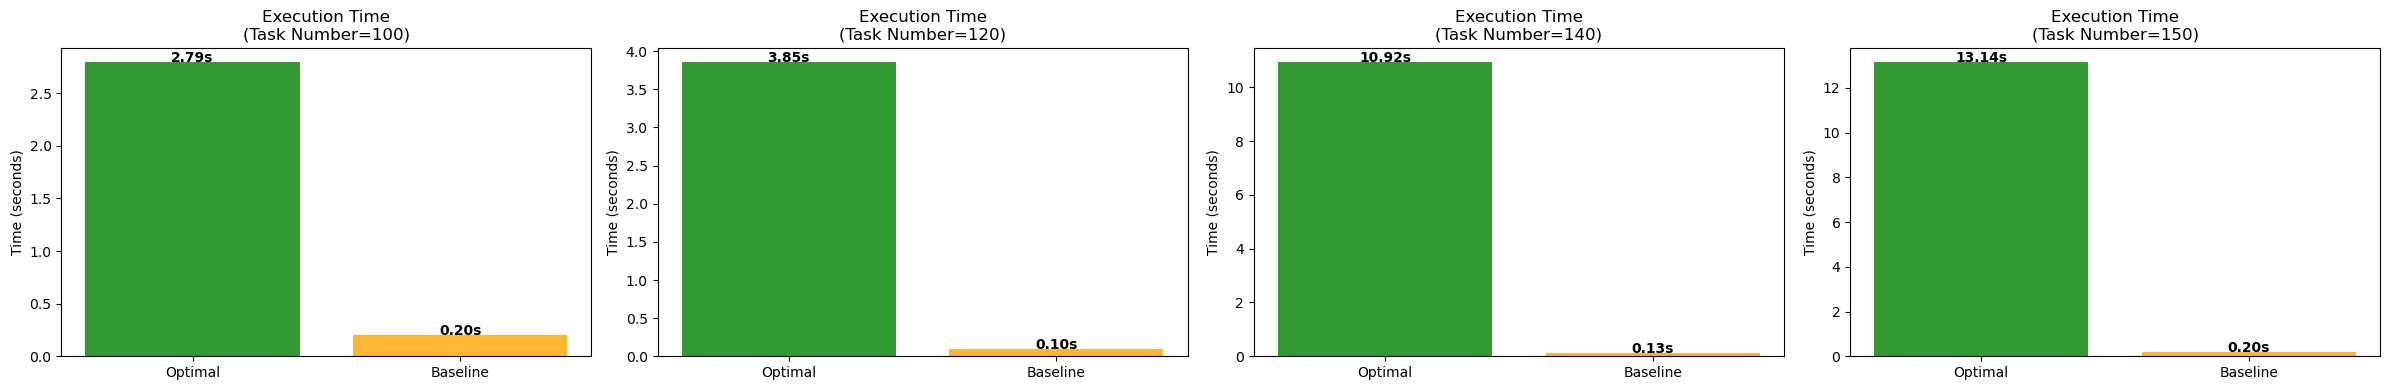

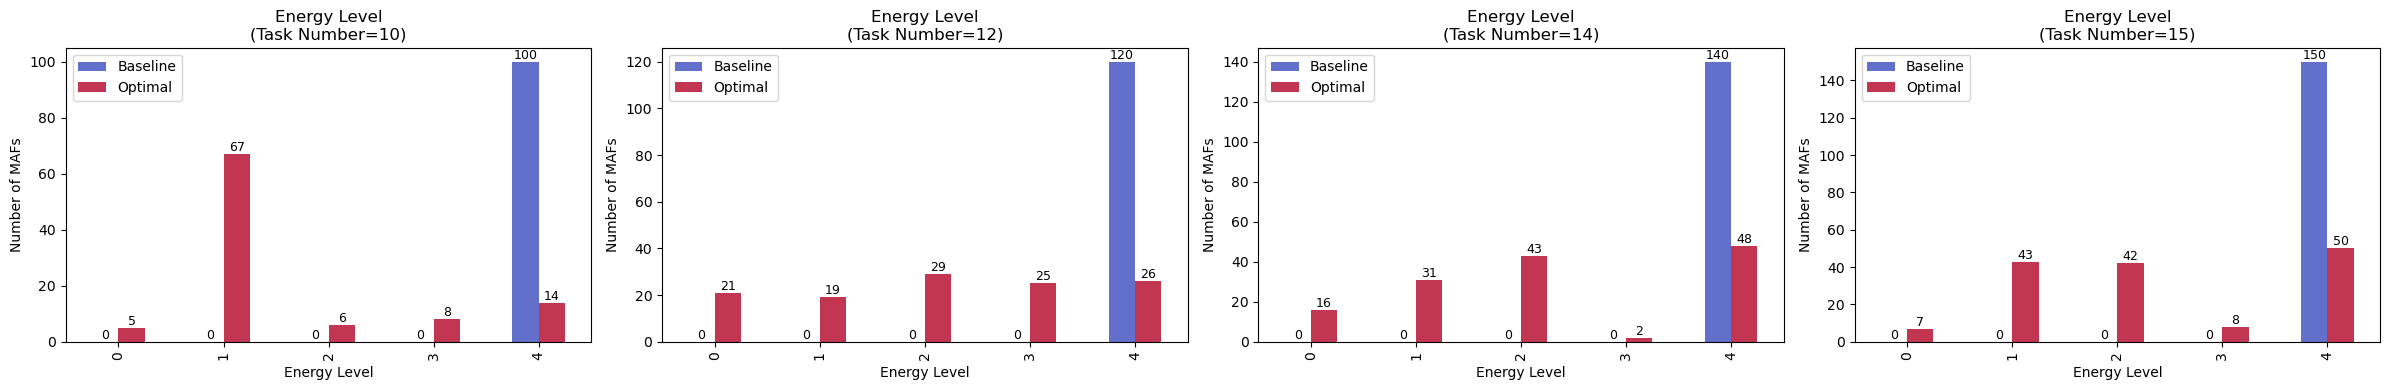

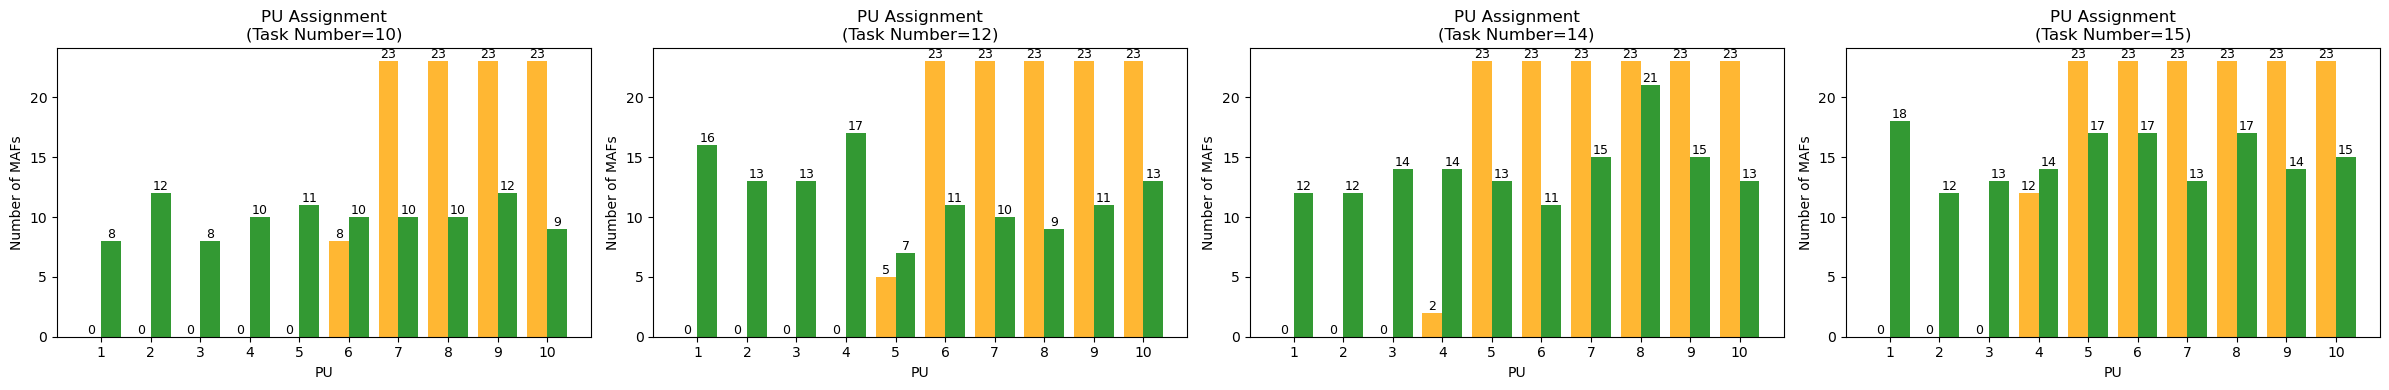

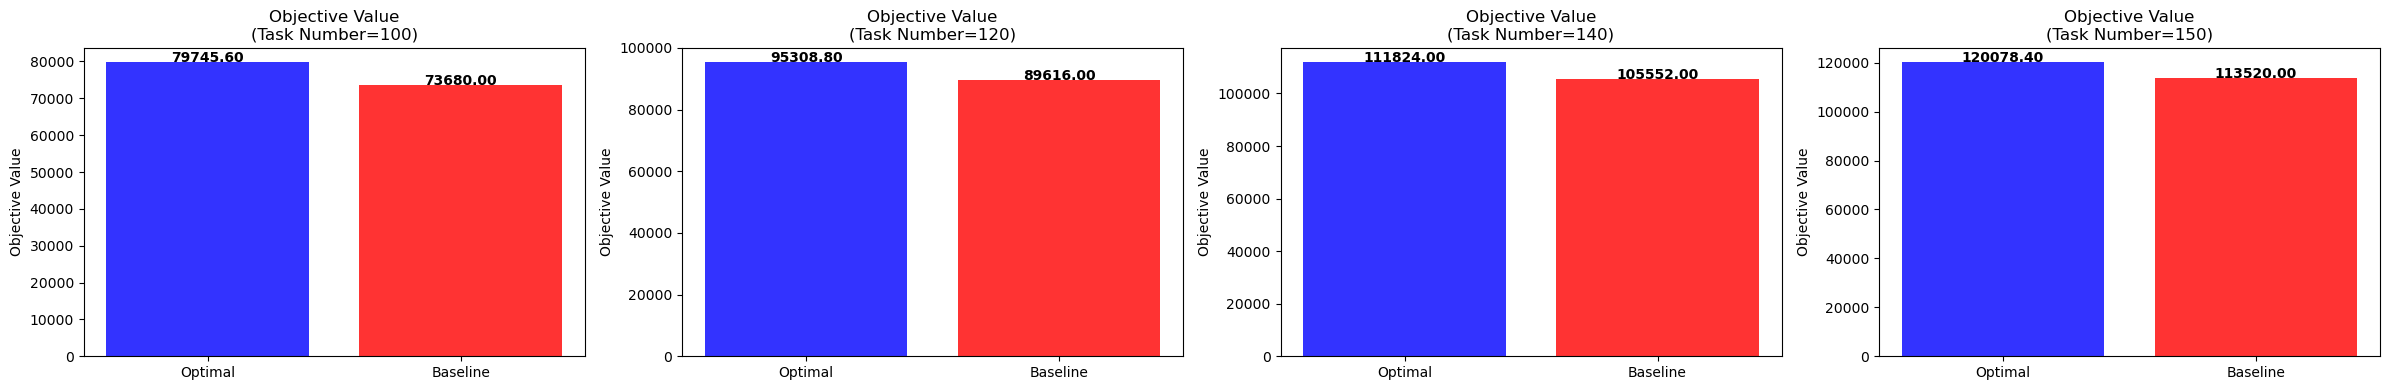

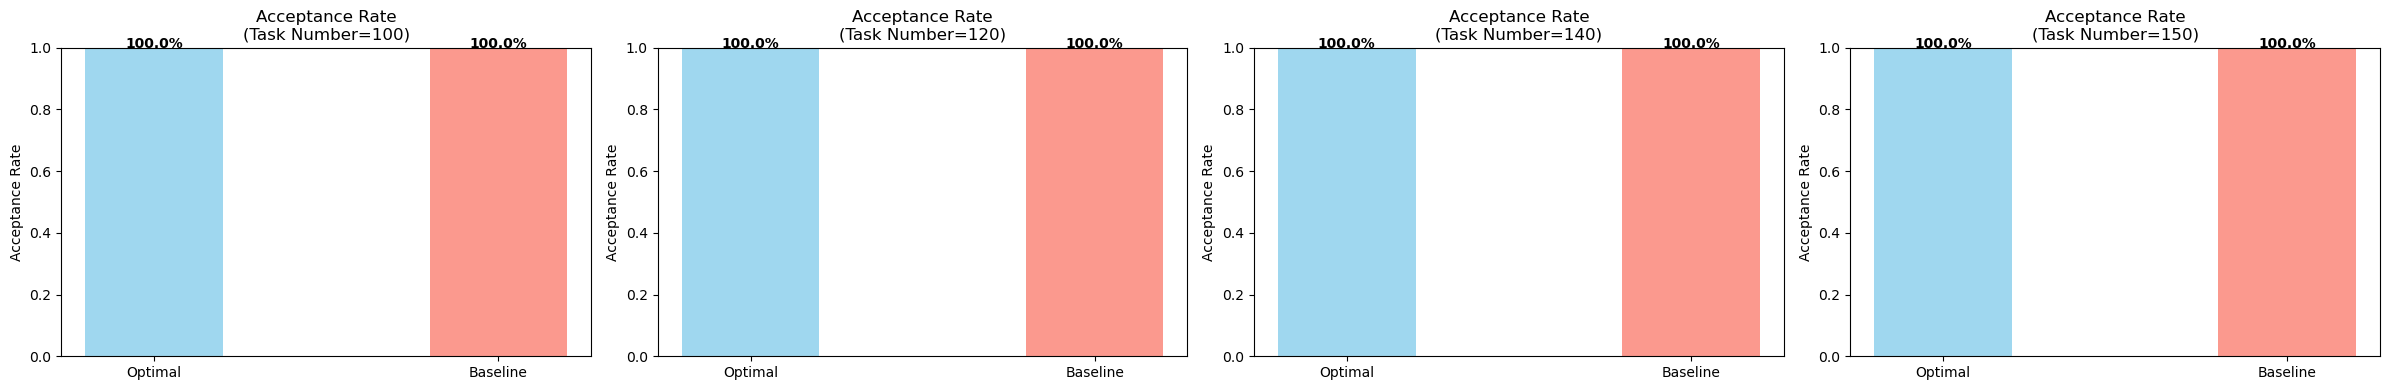

In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 10  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [1000] * m  # Maximum energy consumption per processing unit
CPU_capacity = [1500] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 10000  # Total system resource capacity
P_idle = [2] * m  # Idle power consumption per PU
T_total = 300  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption
# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [150] * num_chains 


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")

    for k in range(num_chains):
        chain = chain_tasks[k]
        
        # Task chain `k` failure logic: if any `delta[i] = 0` within `chain_tasks[k]`, then `z_chain_k[k] = 0`.
        for i in chain:
            model.addConstr(z_chain_k[k] <= delta[i], name=f"ChainActivation_{k}_Task_{i}")

        #  Calculation of end-to-end delay in the task chain (execution time + communication delay)
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) for i in chain)
        communication_delay =  len(chain) - 1  

        #  End-to-end (E2E) delay constraints (effective only if `z_chain_k[k] = 1`)
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # mafs constraints
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i])

    # Limiting PU resources (corrected version)
    for j in range(m):
        execution_time = quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        idle_time = T_total - execution_time  
        model.addConstr(U_j[j] == execution_time / T_total)
        model.addConstr(E_PU[j] == P_idle[j]*idle_time + (P_max[j]-P_idle[j])*U_j[j]*T_total)
        model.addConstr(E_PU[j] <= E_PU_max[j])


    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    # Baseline only modifies the energy level selection logic, other constraints are consistent with Optimal.
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    return model if model.status == GRB.OPTIMAL else None


# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  
       
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  
    
    return maf_energy_levels, maf_pu_assignments


optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)



# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 


task_numbers = [100, 120, 140, 150]
test_param_list = task_numbers
test_param_name = "Task Number"

results = []

fig_time, axes_time = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_energy, axes_energy = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_pu, axes_pu = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_obj, axes_obj = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_accept, axes_accept = plt.subplots(1, len(test_param_list), figsize=(24, 4))

for idx, param_value in enumerate(test_param_list):

    n = param_value 

    chain_length = 10
    num_chains = n // chain_length
    chain_tasks = {i: list(range(i * chain_length, (i + 1) * chain_length)) for i in range(num_chains)}

    L_max = [150] * num_chains 


    start_time_opt = time.perf_counter()
    optimal_model = run_gurobi_model(1000, 4, 1, baseline=False)
    execution_time_opt = time.perf_counter() - start_time_opt

    start_time_base = time.perf_counter()
    baseline_model = run_gurobi_model(1000, 4, 1, baseline=True)
    execution_time_base = time.perf_counter() - start_time_base

    optimal_obj = optimal_model.objVal if optimal_model else None
    baseline_obj = baseline_model.objVal if baseline_model else None

    acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
    acceptance_rate_base = calculate_acceptance_rate(baseline_model)

    optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
    baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

    results.append({
        test_param_name: param_value,
        'Optimal_Obj': optimal_obj,
        'Baseline_Obj': baseline_obj,
        'Optimal_Time': execution_time_opt,
        'Baseline_Time': execution_time_base,
        'Optimal_Acceptance': acceptance_rate_opt,
        'Baseline_Acceptance': acceptance_rate_base,
    })

    # === 执行时间可视化 ===
    axes_time[idx].bar(["Optimal", "Baseline"], [execution_time_opt, execution_time_base],
                       color=["green", "orange"], alpha=0.8)
    axes_time[idx].set_title(f"Execution Time\n({test_param_name}={param_value})")
    axes_time[idx].set_ylabel('Time (seconds)')
    for i, v in enumerate([execution_time_opt, execution_time_base]):
        axes_time[idx].text(i, v, f'{v:.2f}s', ha='center', fontsize=10, fontweight='bold')

       # === Energy Level ===
    df_energy = pd.DataFrame({
        "Baseline": np.bincount(baseline_energy_levels, minlength=K + 1)[1:],
        "Optimal": np.bincount(optimal_energy_levels, minlength=K + 1)[1:]
    })
    df_energy.plot(kind="bar", ax=axes_energy[idx], colormap="coolwarm", alpha=0.8)
    axes_energy[idx].set_title(f"Energy Level\n({test_param_name}={num_chains})")
    axes_energy[idx].set_xlabel("Energy Level")
    axes_energy[idx].set_ylabel("Number of MAFs")

   
    for container in axes_energy[idx].containers:
        axes_energy[idx].bar_label(container, fontsize=9)


    # === PU Assignment ===
    df_pu = pd.DataFrame({
        "Baseline": np.bincount(baseline_pu_assignments, minlength=m + 1)[1:].astype(int),
        "Optimal": np.bincount(optimal_pu_assignments, minlength=m + 1)[1:].astype(int)
    })
    bar_width = 0.4
    x = np.arange(1, m + 1)

    bars_baseline = axes_pu[idx].bar(x - bar_width/2, df_pu["Baseline"], width=bar_width, color="orange", alpha=0.8, label="Baseline")
    bars_optimal = axes_pu[idx].bar(x + bar_width/2, df_pu["Optimal"], width=bar_width, color="green", alpha=0.8, label="Optimal")

    axes_pu[idx].set_title(f"PU Assignment\n({test_param_name}={num_chains})")
    axes_pu[idx].set_xlabel("PU")
    axes_pu[idx].set_ylabel("Number of MAFs")
    axes_pu[idx].set_xticks(np.arange(1, m + 1))

    
    axes_pu[idx].bar_label(bars_baseline, fontsize=9)
    axes_pu[idx].bar_label(bars_optimal, fontsize=9)

    
    axes_obj[idx].bar(["Optimal", "Baseline"], [optimal_obj, baseline_obj],
                      color=["blue", "red"], alpha=0.8)
    axes_obj[idx].set_title(f"Objective Value\n({test_param_name}={param_value})")
    axes_obj[idx].set_ylabel("Objective Value")
    for i, v in enumerate([optimal_obj, baseline_obj]):
        axes_obj[idx].text(i, v, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")

    # === Acceptance Rate 对比可视化 ===
    axes_accept[idx].bar(["Optimal", "Baseline"], [acceptance_rate_opt, acceptance_rate_base],
                         color=["skyblue", "salmon"], alpha=0.8, width=0.4)
    axes_accept[idx].set_ylim(0, 1)
    axes_accept[idx].set_title(f"Acceptance Rate\n({test_param_name}={param_value})")
    axes_accept[idx].set_ylabel("Acceptance Rate")
    for i, v in enumerate([acceptance_rate_opt, acceptance_rate_base]):
        axes_accept[idx].text(i, v, f"{v:.1%}", ha='center', fontsize=10, fontweight='bold')

# 布局调整，显示图表
fig_time.tight_layout()
fig_energy.tight_layout()
fig_pu.tight_layout()
fig_obj.tight_layout()
fig_accept.tight_layout()

plt.show()



Set parameter Username
Set parameter LicenseID to value 2599825
Academic license - for non-commercial use only - expires 2025-12-16


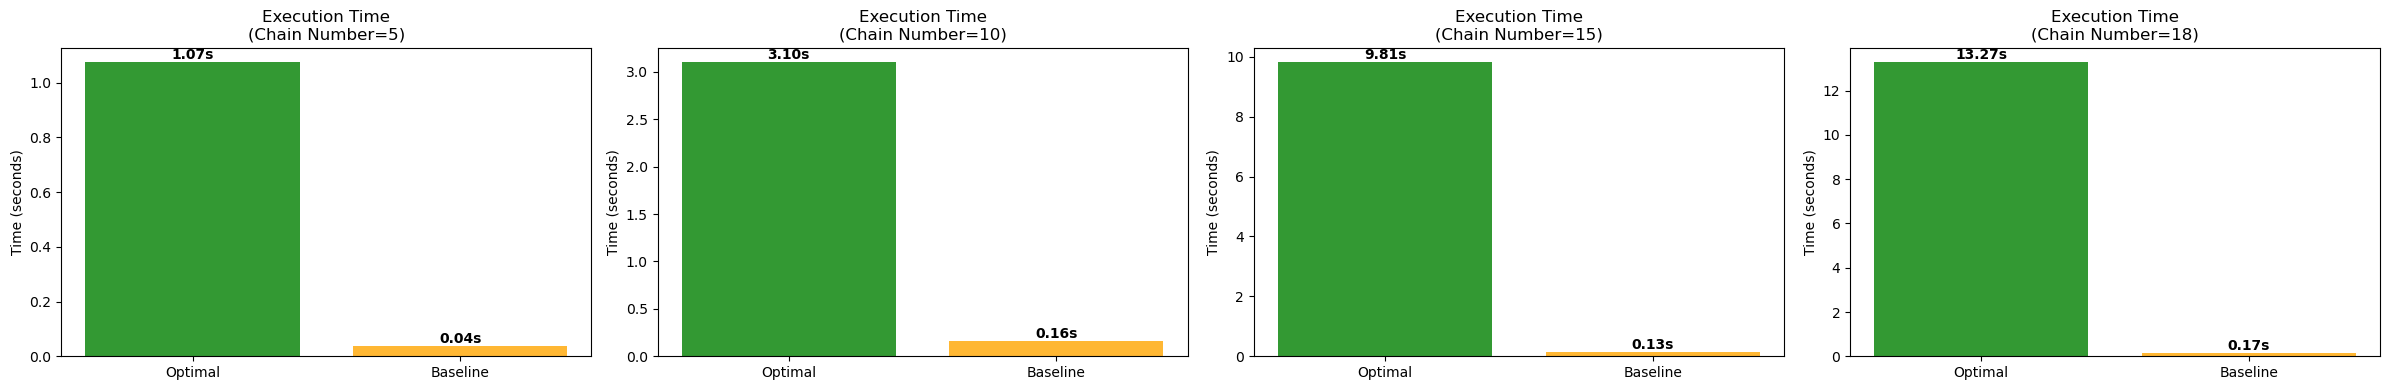

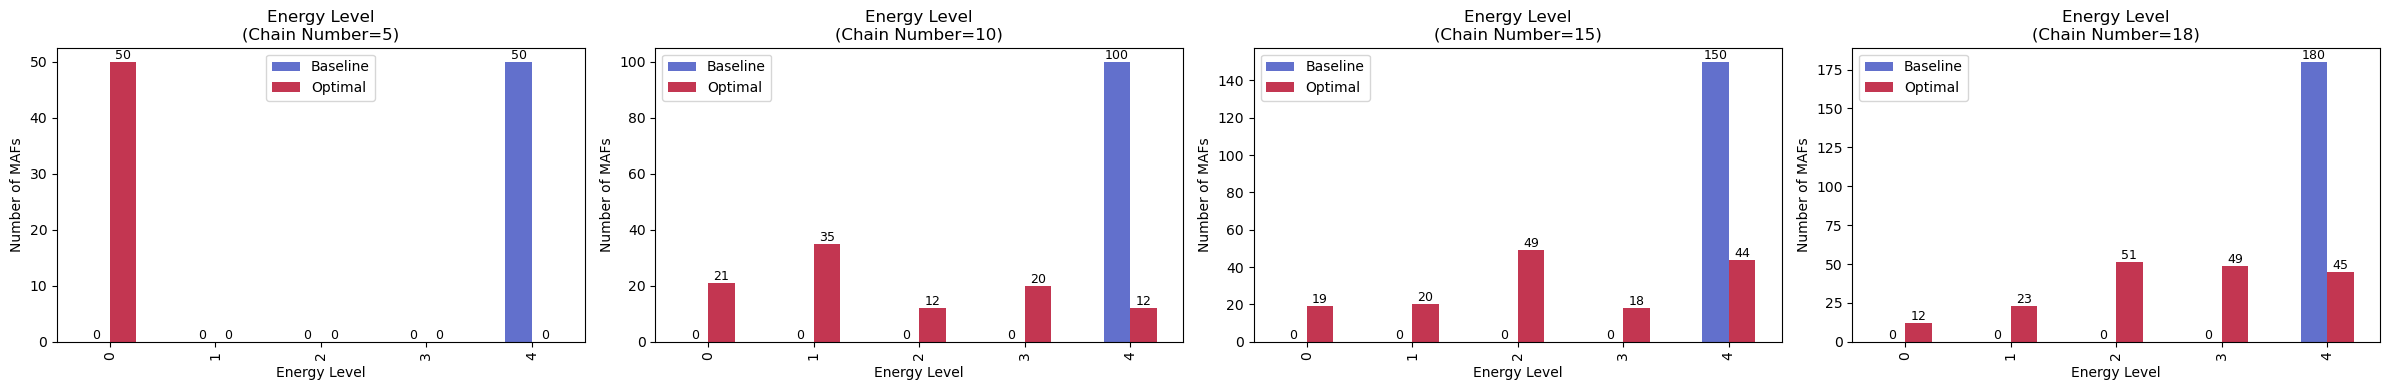

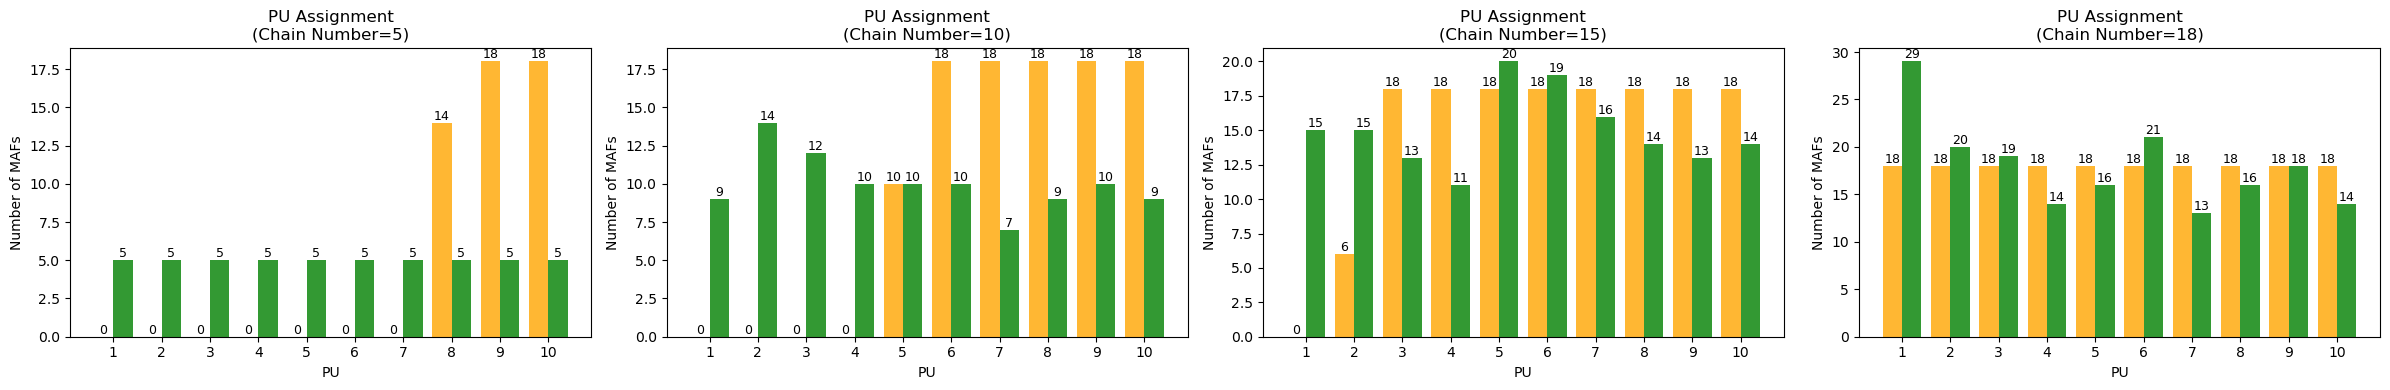

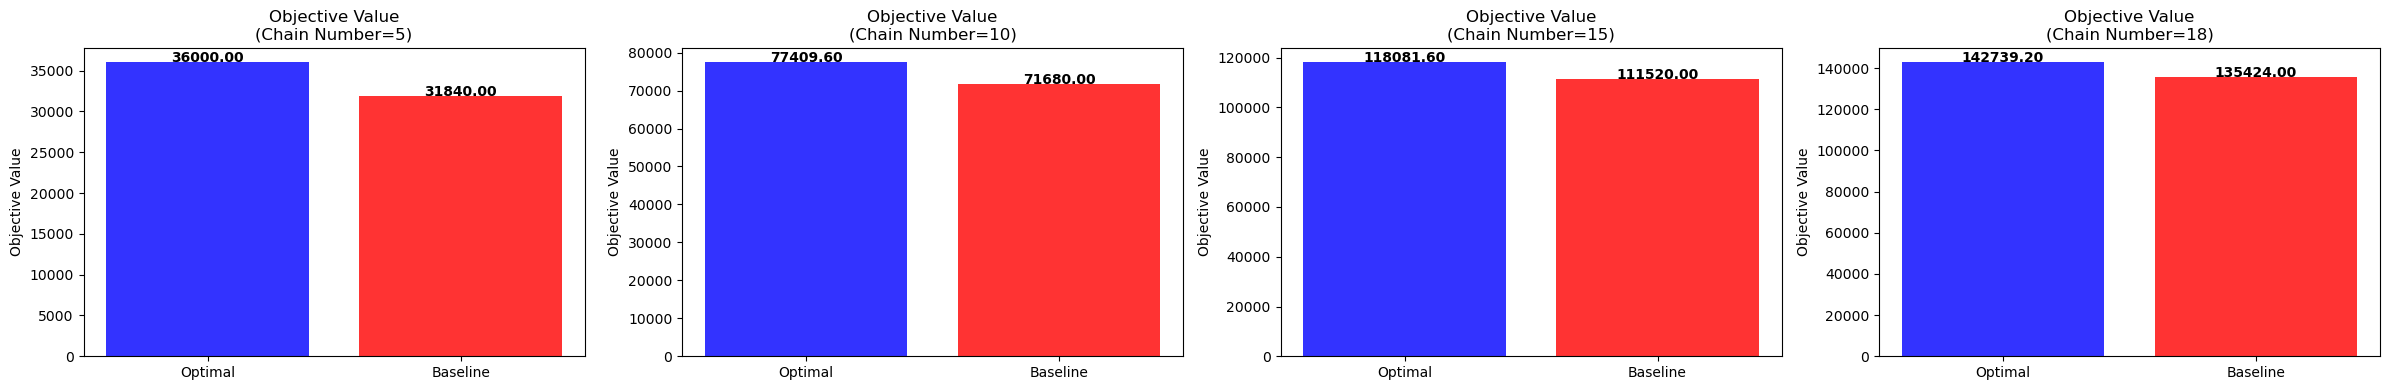

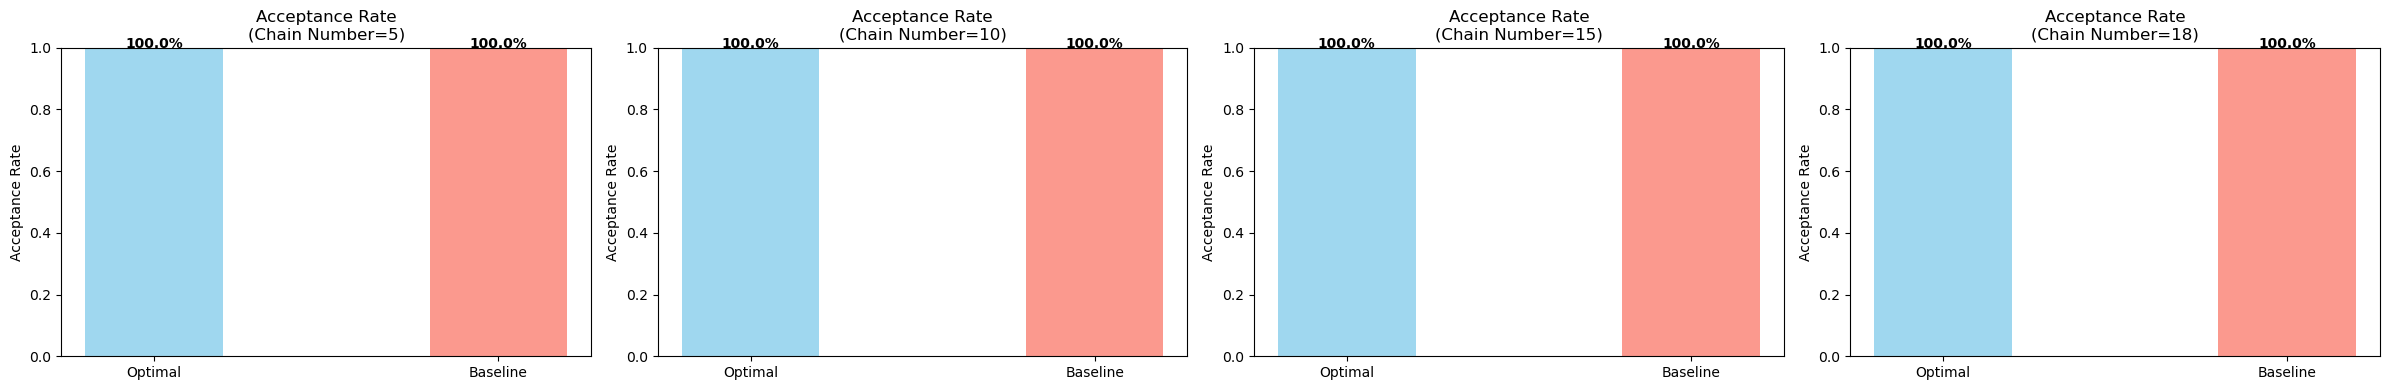

In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 10  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [1200] * m  # Maximum energy consumption per processing unit
CPU_capacity = [1200] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 14000  # Total system resource capacity
P_idle = [2] * m  # Idle power consumption per PU
T_total = 400  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption

# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [150] * num_chains 


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")

    for k in range(num_chains):
        chain = chain_tasks[k]
        
        # Task chain `k` failure logic: if any `delta[i] = 0` within `chain_tasks[k]`, then `z_chain_k[k] = 0`.
        for i in chain:
            model.addConstr(z_chain_k[k] <= delta[i], name=f"ChainActivation_{k}_Task_{i}")

        #  Calculation of end-to-end delay in the task chain (execution time + communication delay)
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) for i in chain)
        communication_delay =  len(chain) - 1  

        #  End-to-end (E2E) delay constraints (effective only if `z_chain_k[k] = 1`)
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # mafs constraints
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i])

    # Limiting PU resources (corrected version)
    for j in range(m):
        execution_time = quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        idle_time = T_total - execution_time  
        model.addConstr(U_j[j] == execution_time / T_total)
        model.addConstr(E_PU[j] == P_idle[j]*idle_time + (P_max[j]-P_idle[j])*U_j[j]*T_total)
        model.addConstr(E_PU[j] <= E_PU_max[j])


    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    # Baseline only modifies the energy level selection logic, other constraints are consistent with Optimal.
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    return model if model.status == GRB.OPTIMAL else None


# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  
       
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  
    
    return maf_energy_levels, maf_pu_assignments


optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)



# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 

chain_numbers = [5, 10, 15, 18]
test_param_list = chain_numbers
test_param_name = "Chain Number"

results = []

fig_time, axes_time = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_energy, axes_energy = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_pu, axes_pu = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_obj, axes_obj = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_accept, axes_accept = plt.subplots(1, len(test_param_list), figsize=(24, 4))

for idx, num_chains in enumerate(test_param_list):

    
    chain_length = 10
    n = num_chains * chain_length
    chain_tasks = {i: list(range(i * chain_length, (i + 1) * chain_length)) for i in range(num_chains)}

    #
    L_max = [150] * num_chains  

    # Optimal 
    start_time_opt = time.perf_counter()
    optimal_model = run_gurobi_model(1000, 4, 1, baseline=False)
    execution_time_opt = time.perf_counter() - start_time_opt

    # Baseline
    start_time_base = time.perf_counter()
    baseline_model = run_gurobi_model(1000, 4, 1, baseline=True)
    execution_time_base = time.perf_counter() - start_time_base

    optimal_obj = optimal_model.objVal if optimal_model else None
    baseline_obj = baseline_model.objVal if baseline_model else None

    acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
    acceptance_rate_base = calculate_acceptance_rate(baseline_model)

    optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
    baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

    results.append({
        test_param_name: num_chains,
        'Optimal_Obj': optimal_obj,
        'Baseline_Obj': baseline_obj,
        'Optimal_Time': execution_time_opt,
        'Baseline_Time': execution_time_base,
        'Optimal_Acceptance': acceptance_rate_opt,
        'Baseline_Acceptance': acceptance_rate_base,
    })

    # === Execution Time ===
    axes_time[idx].bar(["Optimal", "Baseline"], [execution_time_opt, execution_time_base],
                       color=["green", "orange"], alpha=0.8)
    axes_time[idx].set_title(f"Execution Time\n({test_param_name}={num_chains})")
    axes_time[idx].set_ylabel('Time (seconds)')
    for i, v in enumerate([execution_time_opt, execution_time_base]):
        axes_time[idx].text(i, v, f'{v:.2f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # === Energy Level ===
    df_energy = pd.DataFrame({
        "Baseline": np.bincount(baseline_energy_levels, minlength=K + 1)[1:],
        "Optimal": np.bincount(optimal_energy_levels, minlength=K + 1)[1:]
    })
    df_energy.plot(kind="bar", ax=axes_energy[idx], colormap="coolwarm", alpha=0.8)
    axes_energy[idx].set_title(f"Energy Level\n({test_param_name}={num_chains})")
    axes_energy[idx].set_xlabel("Energy Level")
    axes_energy[idx].set_ylabel("Number of MAFs")

    # 🚩 添加数值标注
    for container in axes_energy[idx].containers:
        axes_energy[idx].bar_label(container, fontsize=9)


    # === PU Assignment ===
    df_pu = pd.DataFrame({
        "Baseline": np.bincount(baseline_pu_assignments, minlength=m + 1)[1:].astype(int),
        "Optimal": np.bincount(optimal_pu_assignments, minlength=m + 1)[1:].astype(int)
    })
    bar_width = 0.4
    x = np.arange(1, m + 1)

    bars_baseline = axes_pu[idx].bar(x - bar_width/2, df_pu["Baseline"], width=bar_width, color="orange", alpha=0.8, label="Baseline")
    bars_optimal = axes_pu[idx].bar(x + bar_width/2, df_pu["Optimal"], width=bar_width, color="green", alpha=0.8, label="Optimal")

    axes_pu[idx].set_title(f"PU Assignment\n({test_param_name}={num_chains})")
    axes_pu[idx].set_xlabel("PU")
    axes_pu[idx].set_ylabel("Number of MAFs")
    axes_pu[idx].set_xticks(np.arange(1, m + 1))

    # 🚩 添加数值标注
    axes_pu[idx].bar_label(bars_baseline, fontsize=9)
    axes_pu[idx].bar_label(bars_optimal, fontsize=9)

    
    # === Objective Value ===
    axes_obj[idx].bar(["Optimal", "Baseline"], [optimal_obj, baseline_obj], color=["blue", "red"], alpha=0.8)
    axes_obj[idx].set_title(f"Objective Value\n({test_param_name}={num_chains})")
    axes_obj[idx].set_ylabel("Objective Value")
    for i, v in enumerate([optimal_obj, baseline_obj]):
        axes_obj[idx].text(i, v, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")

    # === Acceptance Rate ===
    axes_accept[idx].bar(["Optimal", "Baseline"], [acceptance_rate_opt, acceptance_rate_base], color=["skyblue", "salmon"], alpha=0.8, width=0.4)
    axes_accept[idx].set_ylim(0, 1)
    axes_accept[idx].set_title(f"Acceptance Rate\n({test_param_name}={num_chains})")
    axes_accept[idx].set_ylabel("Acceptance Rate")
    for i, v in enumerate([acceptance_rate_opt, acceptance_rate_base]):
        axes_accept[idx].text(i, v, f"{v:.1%}", ha='center', fontsize=10, fontweight='bold')

# 布局调整
fig_time.tight_layout()
fig_energy.tight_layout()
fig_pu.tight_layout()
fig_obj.tight_layout()
fig_accept.tight_layout()

plt.show()



Set parameter Username
Set parameter LicenseID to value 2599825
Academic license - for non-commercial use only - expires 2025-12-16


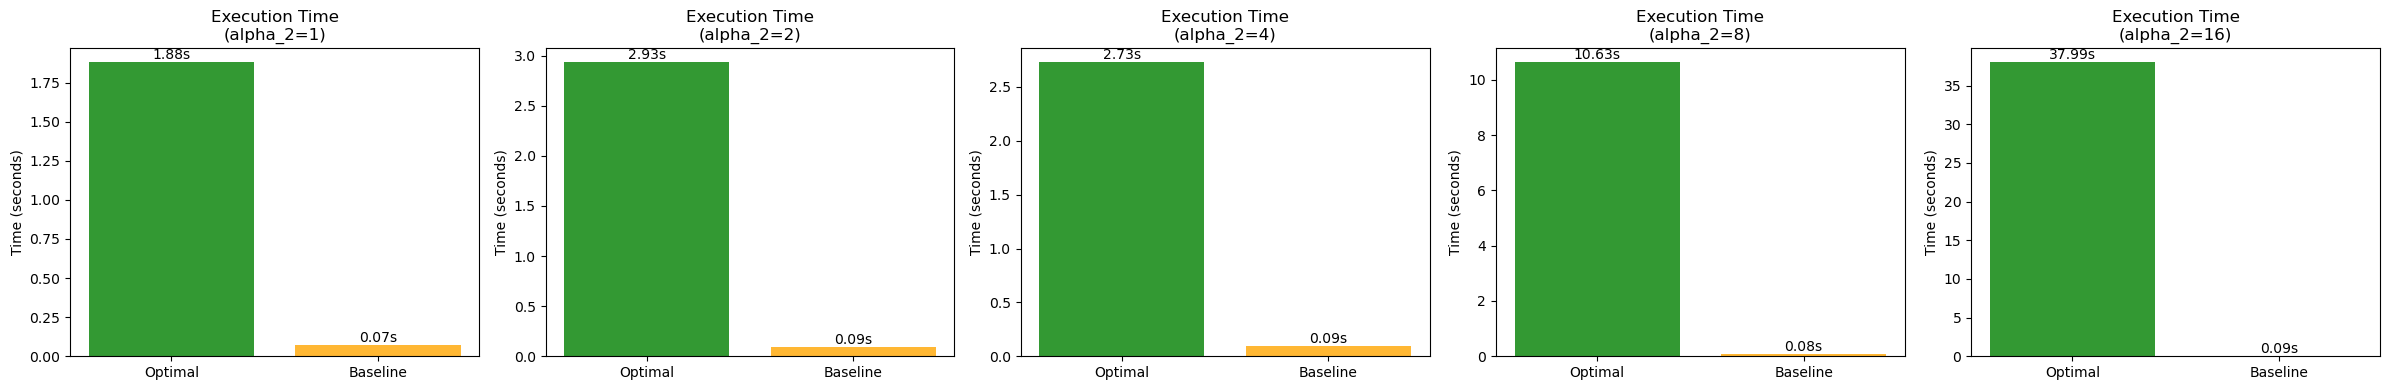

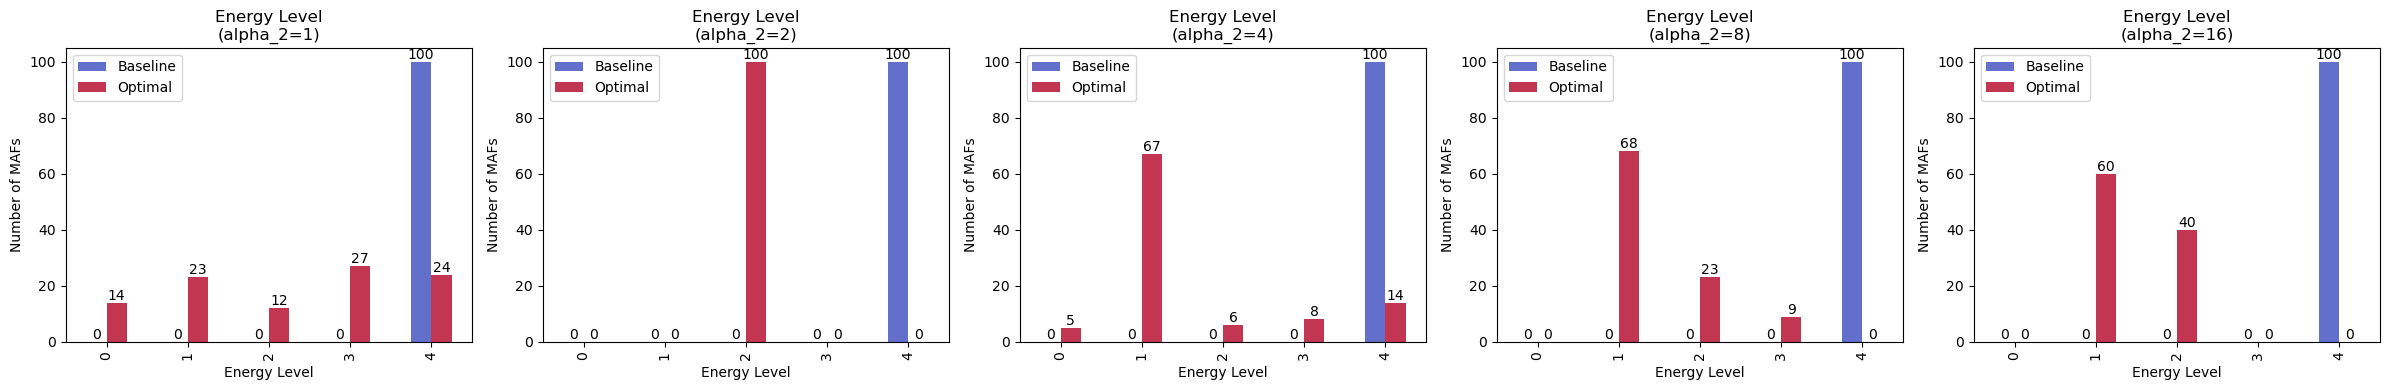

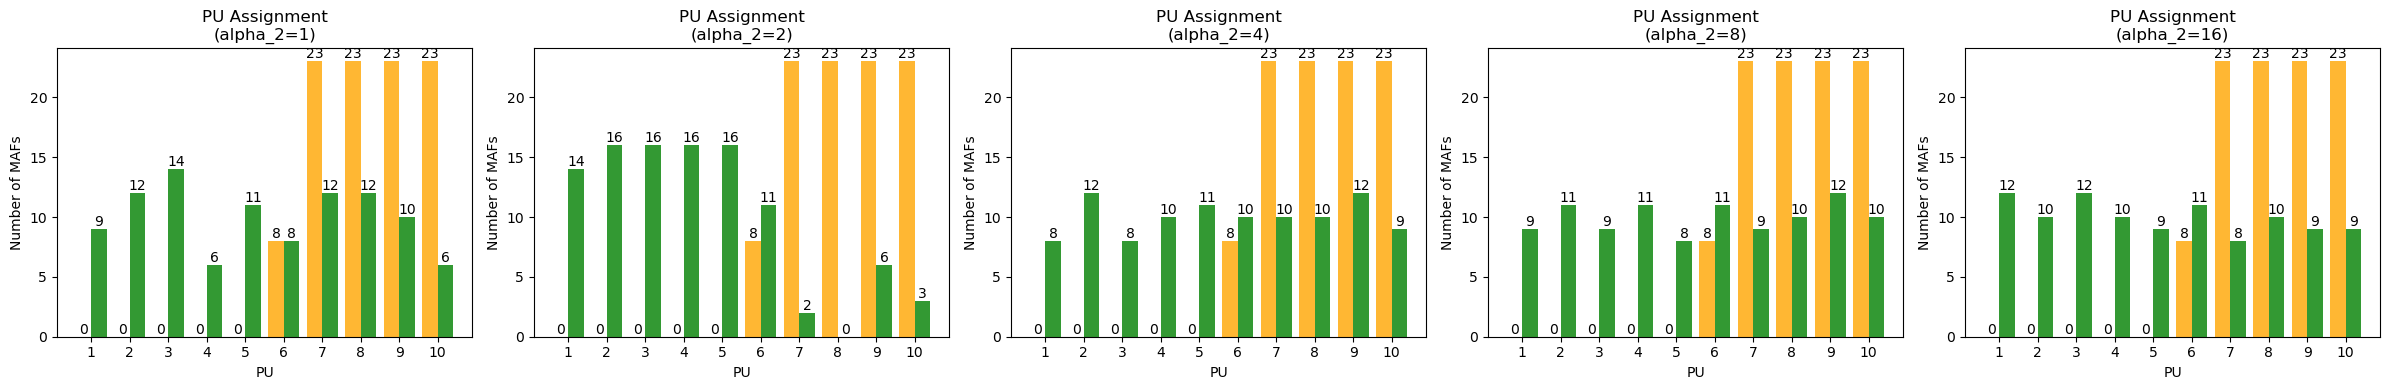

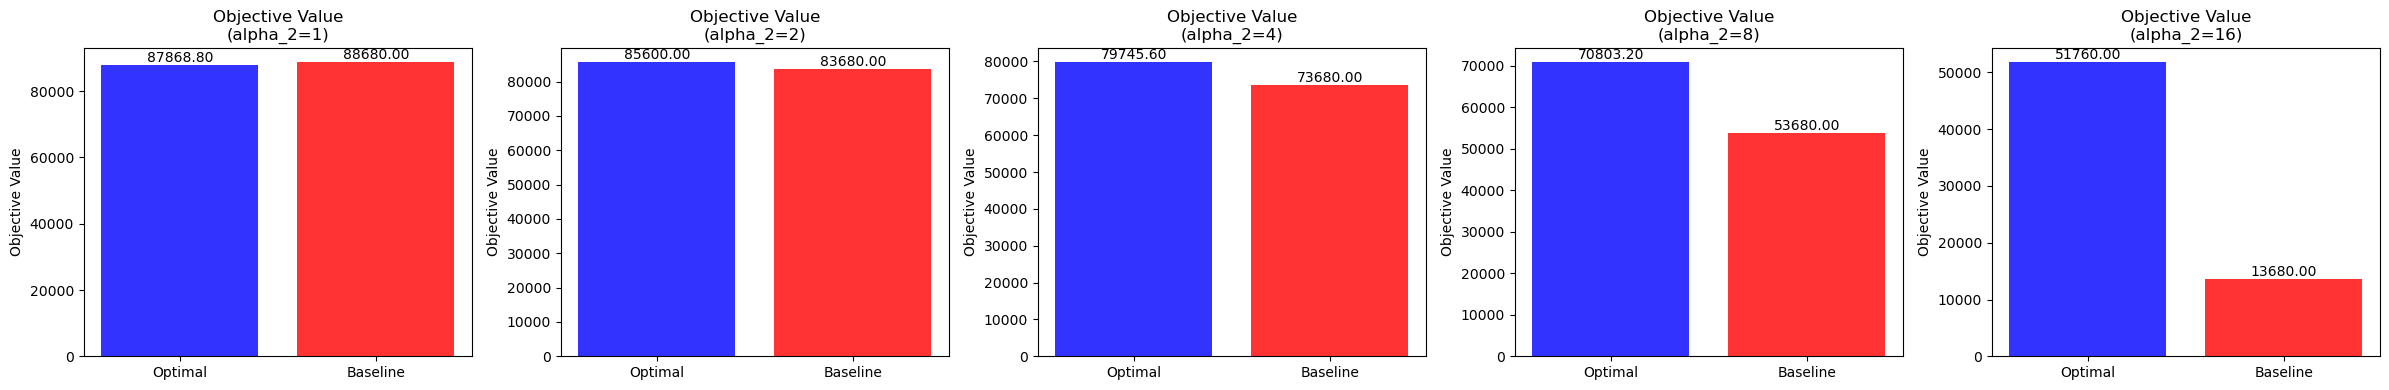

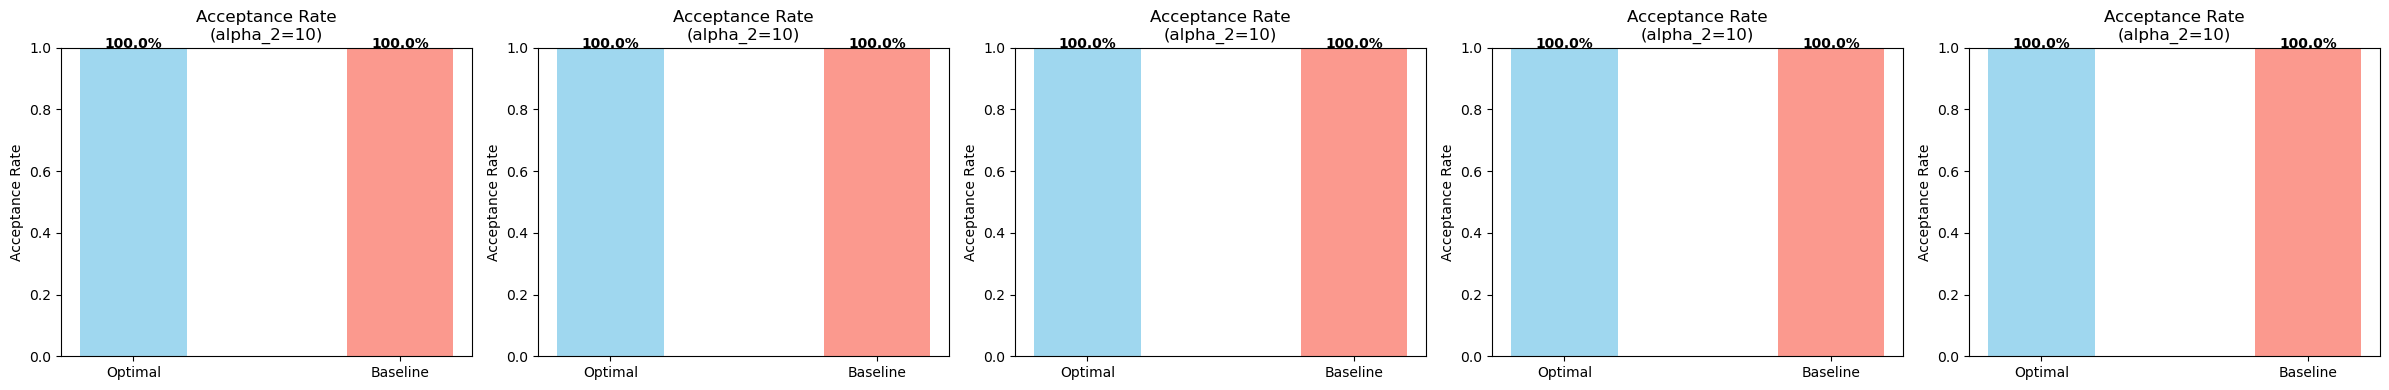

In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 10  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [1000] * m  # Maximum energy consumption per processing unit
CPU_capacity = [1500] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 10000  # Total system resource capacity
P_idle = [2] * m  # Idle power consumption per PU
T_total = 300  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption
# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [150] * num_chains 


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")

    for k in range(num_chains):
        chain = chain_tasks[k]
        
        # Task chain `k` failure logic: if any `delta[i] = 0` within `chain_tasks[k]`, then `z_chain_k[k] = 0`.
        for i in chain:
            model.addConstr(z_chain_k[k] <= delta[i], name=f"ChainActivation_{k}_Task_{i}")

        #  Calculation of end-to-end delay in the task chain (execution time + communication delay)
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) for i in chain)
        communication_delay =  len(chain) - 1  

        #  End-to-end (E2E) delay constraints (effective only if `z_chain_k[k] = 1`)
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # mafs constraints
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i])

    # Limiting PU resources (corrected version)
    for j in range(m):
        execution_time = quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        idle_time = T_total - execution_time  
        model.addConstr(U_j[j] == execution_time / T_total)
        model.addConstr(E_PU[j] == P_idle[j]*idle_time + (P_max[j]-P_idle[j])*U_j[j]*T_total)
        model.addConstr(E_PU[j] <= E_PU_max[j])


    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    # Baseline only modifies the energy level selection logic, other constraints are consistent with Optimal.
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    return model if model.status == GRB.OPTIMAL else None


# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  
       
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  
    
    return maf_energy_levels, maf_pu_assignments


optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)



# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 


alpha_1 = 1000
alpha_PU = 1
alpha_2_list = [1, 2, 4, 8, 16]

test_param_list = alpha_2_list
test_param_name = "alpha_2"

results = []

fig_time, axes_time = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_energy, axes_energy = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_pu, axes_pu = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_obj, axes_obj = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_accept, axes_accept = plt.subplots(1, len(test_param_list), figsize=(24, 4))

for idx, param_value in enumerate(test_param_list):

    alpha_2 = param_value
    
    # Optimal 
    start_time_opt = time.perf_counter()
    optimal_model = run_gurobi_model(alpha_1, alpha_2, alpha_PU, baseline=False)
    execution_time_opt = time.perf_counter() - start_time_opt

    # Baseline 
    start_time_base = time.perf_counter()
    baseline_model = run_gurobi_model(alpha_1, alpha_2, alpha_PU, baseline=True)
    execution_time_base = time.perf_counter() - start_time_base

    optimal_obj = optimal_model.objVal if optimal_model else None
    baseline_obj = baseline_model.objVal if baseline_model else None

    acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
    acceptance_rate_base = calculate_acceptance_rate(baseline_model)

    optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
    baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

    results.append({
        test_param_name: param_value,
        'Optimal_Obj': optimal_obj,
        'Baseline_Obj': baseline_obj,
        'Optimal_Time': execution_time_opt,
        'Baseline_Time': execution_time_base,
        'Optimal_Acceptance': acceptance_rate_opt,
        'Baseline_Acceptance': acceptance_rate_base,
    })

    
    axes_time[idx].bar(["Optimal", "Baseline"], [execution_time_opt, execution_time_base],
                       color=["green", "orange"], alpha=0.8)
    axes_time[idx].set_title(f"Execution Time\n({test_param_name}={param_value})")
    axes_time[idx].set_ylabel('Time (seconds)')
    axes_time[idx].bar_label(axes_time[idx].containers[0], fmt='%.2fs')

    
    df_energy = pd.DataFrame({
        "Baseline": np.bincount(baseline_energy_levels, minlength=K + 1)[1:],
        "Optimal": np.bincount(optimal_energy_levels, minlength=K + 1)[1:]
    })
    df_energy.plot(kind="bar", ax=axes_energy[idx], colormap="coolwarm", alpha=0.8)
    axes_energy[idx].set_title(f"Energy Level\n({test_param_name}={param_value})")
    axes_energy[idx].set_xlabel("Energy Level")
    axes_energy[idx].set_ylabel("Number of MAFs")
    for container in axes_energy[idx].containers:
        axes_energy[idx].bar_label(container)

   
    df_pu = pd.DataFrame({
        "Baseline": np.bincount(baseline_pu_assignments, minlength=m + 1)[1:].astype(int),
        "Optimal": np.bincount(optimal_pu_assignments, minlength=m + 1)[1:].astype(int)
    })
    bar_width = 0.4
    x = np.arange(1, m + 1)
    bars_baseline = axes_pu[idx].bar(x - bar_width/2, df_pu["Baseline"], width=bar_width, color="orange", alpha=0.8)
    bars_optimal = axes_pu[idx].bar(x + bar_width/2, df_pu["Optimal"], width=bar_width, color="green", alpha=0.8)
    axes_pu[idx].set_title(f"PU Assignment\n({test_param_name}={param_value})")
    axes_pu[idx].set_xlabel("PU")
    axes_pu[idx].set_ylabel("Number of MAFs")
    axes_pu[idx].set_xticks(np.arange(1, m + 1))
    axes_pu[idx].bar_label(bars_baseline)
    axes_pu[idx].bar_label(bars_optimal)

    
    bars_obj = axes_obj[idx].bar(["Optimal", "Baseline"], [optimal_obj, baseline_obj], color=["blue", "red"], alpha=0.8)
    axes_obj[idx].set_title(f"Objective Value\n({test_param_name}={param_value})")
    axes_obj[idx].set_ylabel("Objective Value")
    axes_obj[idx].bar_label(bars_obj, fmt='%.2f')

   
    
    # === Acceptance Rate ===
    axes_accept[idx].bar(["Optimal", "Baseline"], [acceptance_rate_opt, acceptance_rate_base], color=["skyblue", "salmon"], alpha=0.8, width=0.4)
    axes_accept[idx].set_ylim(0, 1)
    axes_accept[idx].set_title(f"Acceptance Rate\n({test_param_name}={num_chains})")
    axes_accept[idx].set_ylabel("Acceptance Rate")
    for i, v in enumerate([acceptance_rate_opt, acceptance_rate_base]):
        axes_accept[idx].text(i, v, f"{v:.1%}", ha='center', fontsize=10, fontweight='bold')

# 调整布局
fig_time.tight_layout()
fig_energy.tight_layout()
fig_pu.tight_layout()
fig_obj.tight_layout()
fig_accept.tight_layout()

plt.show()


Set parameter Username
Set parameter LicenseID to value 2599825
Academic license - for non-commercial use only - expires 2025-12-16


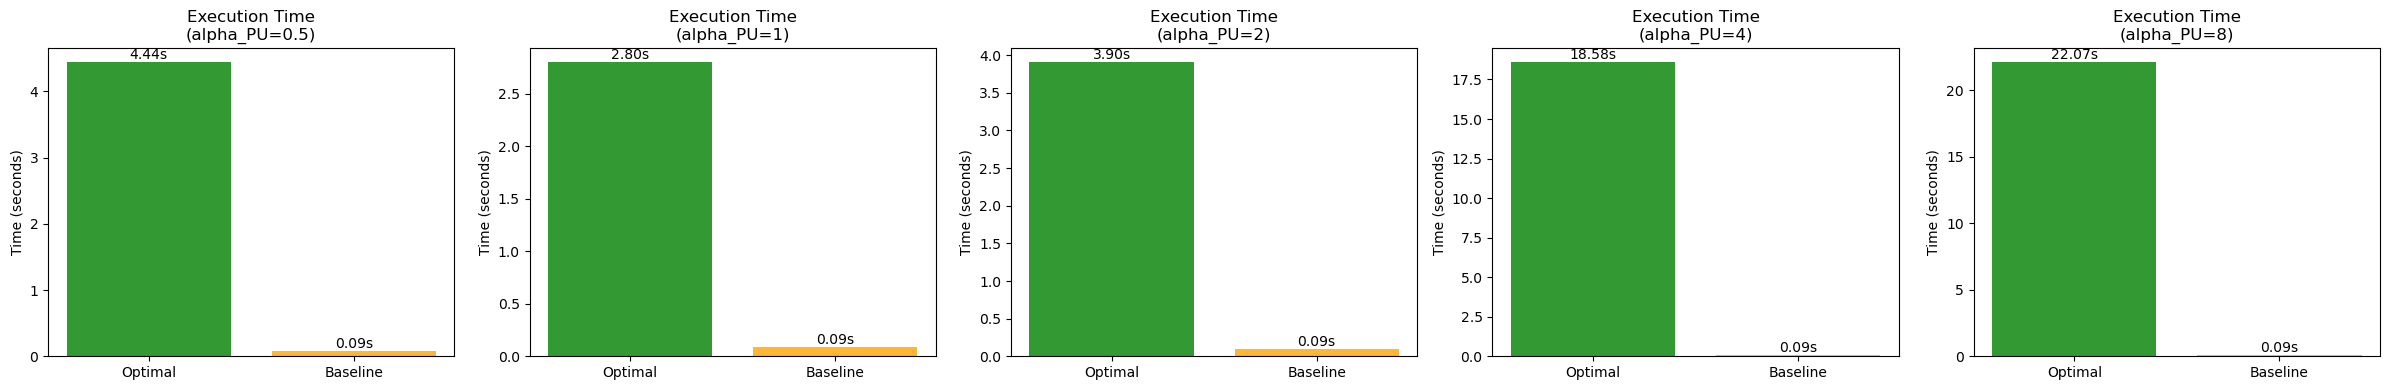

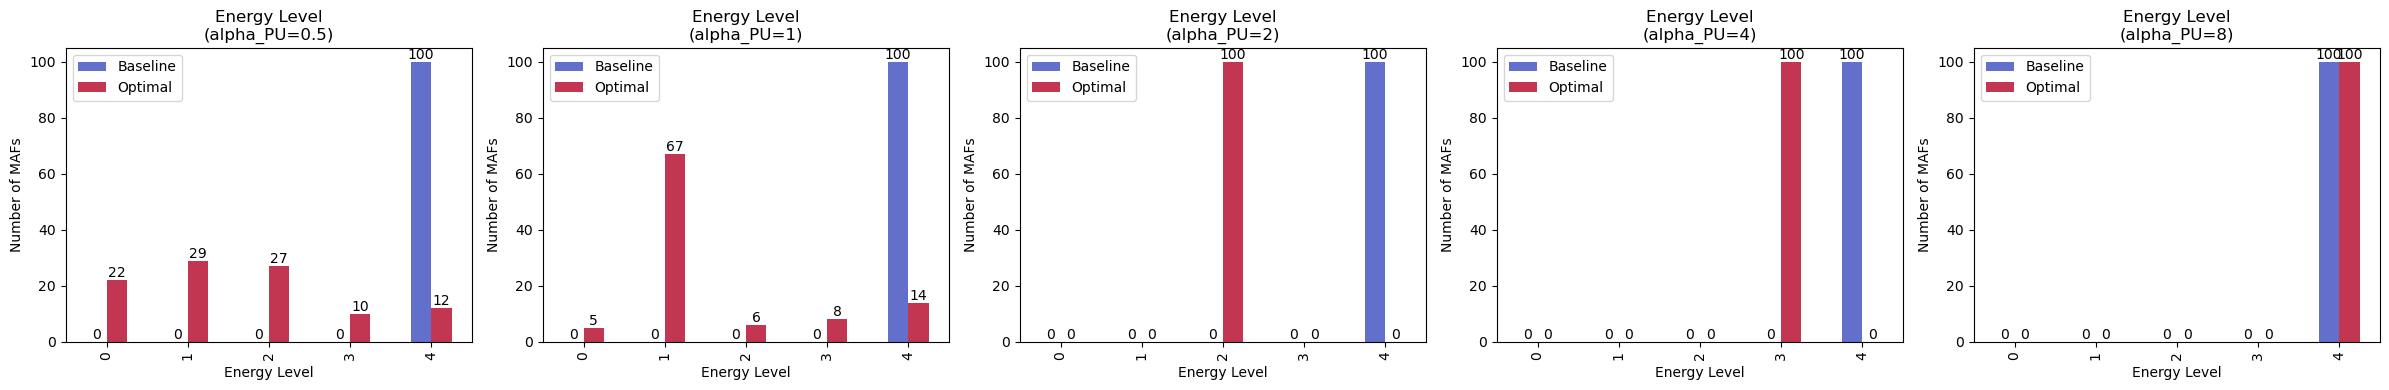

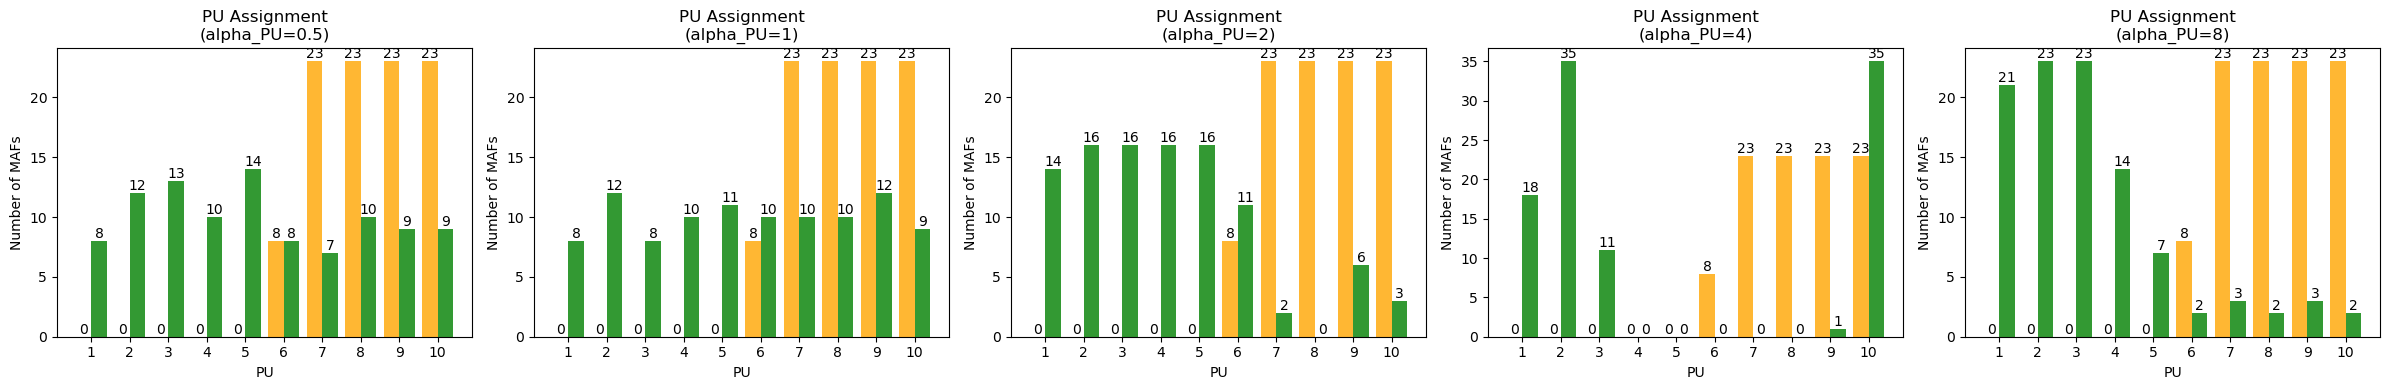

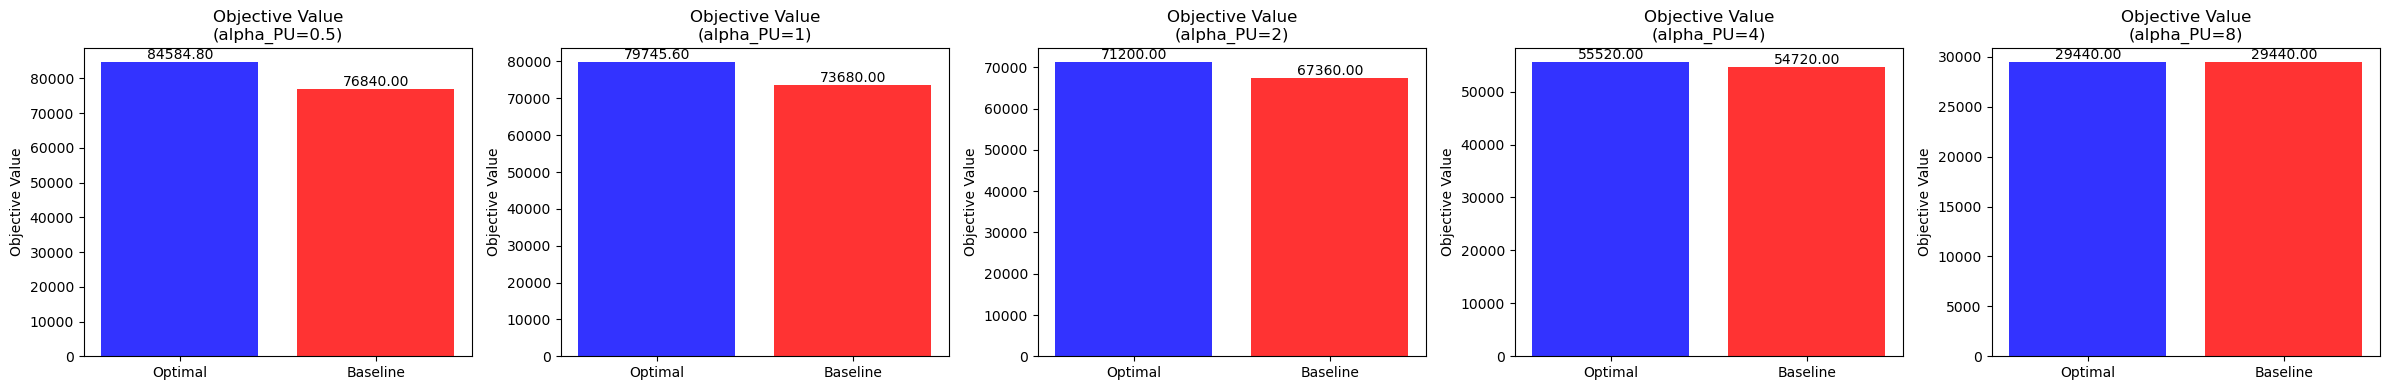

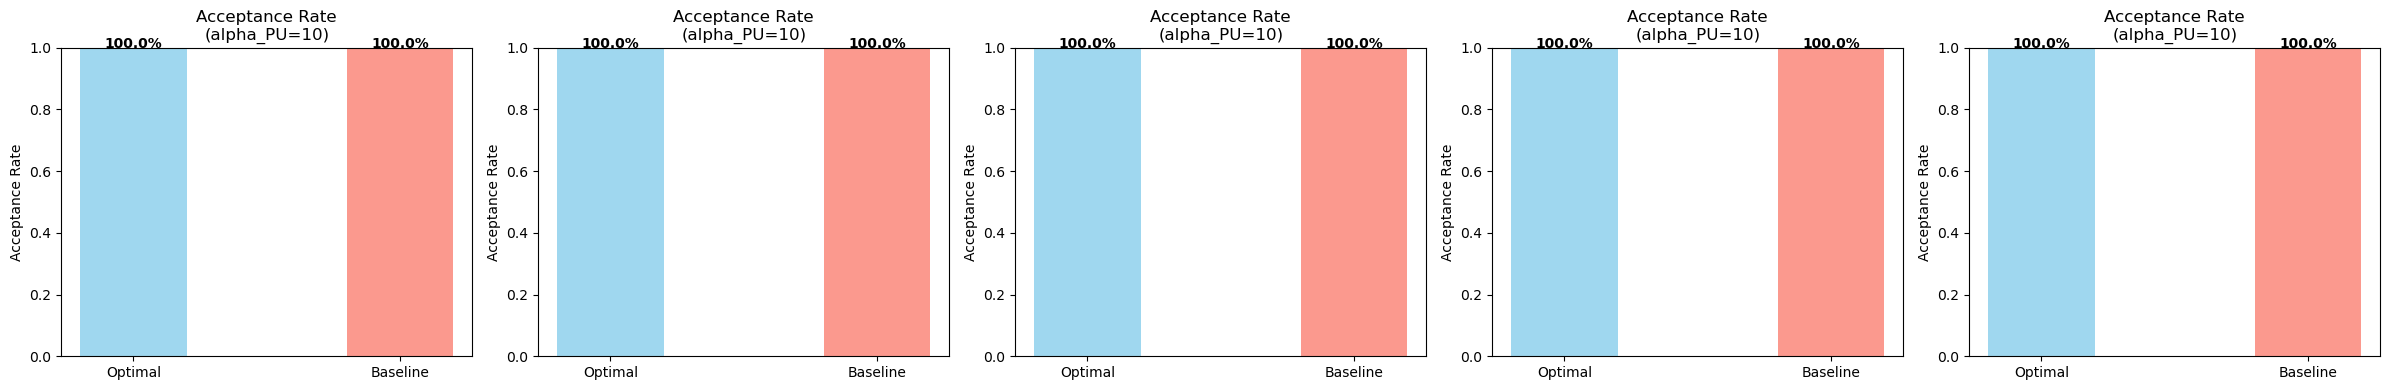

In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 10  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [1000] * m  # Maximum energy consumption per processing unit
CPU_capacity = [1500] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 10000  # Total system resource capacity
P_idle = [2] * m  # Idle power consumption per PU
T_total = 300  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption
# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [150] * num_chains 


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")

    for k in range(num_chains):
        chain = chain_tasks[k]
        
        # Task chain `k` failure logic: if any `delta[i] = 0` within `chain_tasks[k]`, then `z_chain_k[k] = 0`.
        for i in chain:
            model.addConstr(z_chain_k[k] <= delta[i], name=f"ChainActivation_{k}_Task_{i}")

        #  Calculation of end-to-end delay in the task chain (execution time + communication delay)
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) for i in chain)
        communication_delay =  len(chain) - 1  

        #  End-to-end (E2E) delay constraints (effective only if `z_chain_k[k] = 1`)
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # mafs constraints
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i])

    # Limiting PU resources (corrected version)
    for j in range(m):
        execution_time = quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        idle_time = T_total - execution_time  
        model.addConstr(U_j[j] == execution_time / T_total)
        model.addConstr(E_PU[j] == P_idle[j]*idle_time + (P_max[j]-P_idle[j])*U_j[j]*T_total)
        model.addConstr(E_PU[j] <= E_PU_max[j])


    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    # Baseline only modifies the energy level selection logic, other constraints are consistent with Optimal.
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    return model if model.status == GRB.OPTIMAL else None


# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  
       
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  
    
    return maf_energy_levels, maf_pu_assignments


optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)



# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 


alpha_1 = 1000
alpha_2 = 4
alpha_PU_list = [0.5, 1, 2, 4, 8]

test_param_list = alpha_PU_list
test_param_name = "alpha_PU"


results = []

fig_time, axes_time = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_energy, axes_energy = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_pu, axes_pu = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_obj, axes_obj = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_accept, axes_accept = plt.subplots(1, len(test_param_list), figsize=(24, 4))

for idx, param_value in enumerate(test_param_list):

    alpha_PU = param_value
    
    # Optimal 
    start_time_opt = time.perf_counter()
    optimal_model = run_gurobi_model(alpha_1, alpha_2, alpha_PU, baseline=False)
    execution_time_opt = time.perf_counter() - start_time_opt

    # Baseline 
    start_time_base = time.perf_counter()
    baseline_model = run_gurobi_model(alpha_1, alpha_2, alpha_PU, baseline=True)
    execution_time_base = time.perf_counter() - start_time_base

    optimal_obj = optimal_model.objVal if optimal_model else None
    baseline_obj = baseline_model.objVal if baseline_model else None

    acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
    acceptance_rate_base = calculate_acceptance_rate(baseline_model)

    optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
    baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

    results.append({
        test_param_name: param_value,
        'Optimal_Obj': optimal_obj,
        'Baseline_Obj': baseline_obj,
        'Optimal_Time': execution_time_opt,
        'Baseline_Time': execution_time_base,
        'Optimal_Acceptance': acceptance_rate_opt,
        'Baseline_Acceptance': acceptance_rate_base,
    })

    
    axes_time[idx].bar(["Optimal", "Baseline"], [execution_time_opt, execution_time_base],
                       color=["green", "orange"], alpha=0.8)
    axes_time[idx].set_title(f"Execution Time\n({test_param_name}={param_value})")
    axes_time[idx].set_ylabel('Time (seconds)')
    axes_time[idx].bar_label(axes_time[idx].containers[0], fmt='%.2fs')

    
    df_energy = pd.DataFrame({
        "Baseline": np.bincount(baseline_energy_levels, minlength=K + 1)[1:],
        "Optimal": np.bincount(optimal_energy_levels, minlength=K + 1)[1:]
    })
    df_energy.plot(kind="bar", ax=axes_energy[idx], colormap="coolwarm", alpha=0.8)
    axes_energy[idx].set_title(f"Energy Level\n({test_param_name}={param_value})")
    axes_energy[idx].set_xlabel("Energy Level")
    axes_energy[idx].set_ylabel("Number of MAFs")
    for container in axes_energy[idx].containers:
        axes_energy[idx].bar_label(container)

   
    df_pu = pd.DataFrame({
        "Baseline": np.bincount(baseline_pu_assignments, minlength=m + 1)[1:].astype(int),
        "Optimal": np.bincount(optimal_pu_assignments, minlength=m + 1)[1:].astype(int)
    })
    bar_width = 0.4
    x = np.arange(1, m + 1)
    bars_baseline = axes_pu[idx].bar(x - bar_width/2, df_pu["Baseline"], width=bar_width, color="orange", alpha=0.8)
    bars_optimal = axes_pu[idx].bar(x + bar_width/2, df_pu["Optimal"], width=bar_width, color="green", alpha=0.8)
    axes_pu[idx].set_title(f"PU Assignment\n({test_param_name}={param_value})")
    axes_pu[idx].set_xlabel("PU")
    axes_pu[idx].set_ylabel("Number of MAFs")
    axes_pu[idx].set_xticks(np.arange(1, m + 1))
    axes_pu[idx].bar_label(bars_baseline)
    axes_pu[idx].bar_label(bars_optimal)

    
    bars_obj = axes_obj[idx].bar(["Optimal", "Baseline"], [optimal_obj, baseline_obj], color=["blue", "red"], alpha=0.8)
    axes_obj[idx].set_title(f"Objective Value\n({test_param_name}={param_value})")
    axes_obj[idx].set_ylabel("Objective Value")
    axes_obj[idx].bar_label(bars_obj, fmt='%.2f')

   
    
    # === Acceptance Rate ===
    axes_accept[idx].bar(["Optimal", "Baseline"], [acceptance_rate_opt, acceptance_rate_base], color=["skyblue", "salmon"], alpha=0.8, width=0.4)
    axes_accept[idx].set_ylim(0, 1)
    axes_accept[idx].set_title(f"Acceptance Rate\n({test_param_name}={num_chains})")
    axes_accept[idx].set_ylabel("Acceptance Rate")
    for i, v in enumerate([acceptance_rate_opt, acceptance_rate_base]):
        axes_accept[idx].text(i, v, f"{v:.1%}", ha='center', fontsize=10, fontweight='bold')

# 调整布局
fig_time.tight_layout()
fig_energy.tight_layout()
fig_pu.tight_layout()
fig_obj.tight_layout()
fig_accept.tight_layout()

plt.show()


Set parameter Username
Set parameter LicenseID to value 2599825
Academic license - for non-commercial use only - expires 2025-12-16


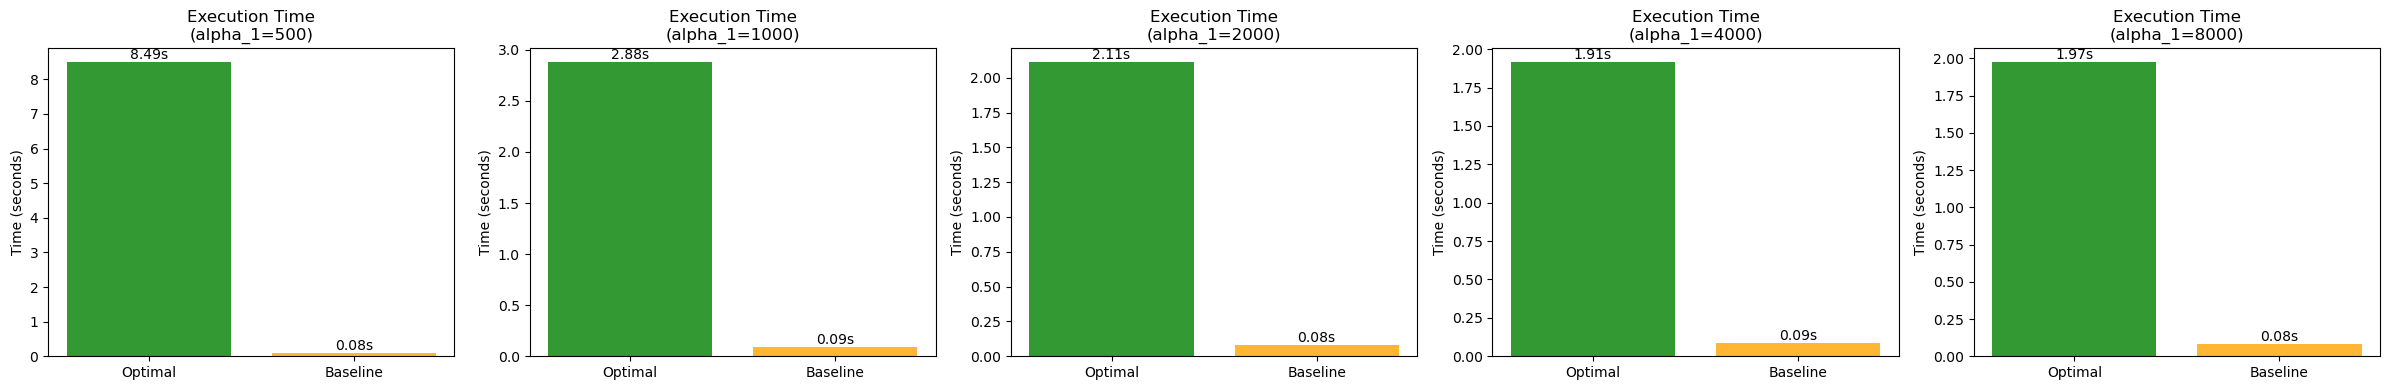

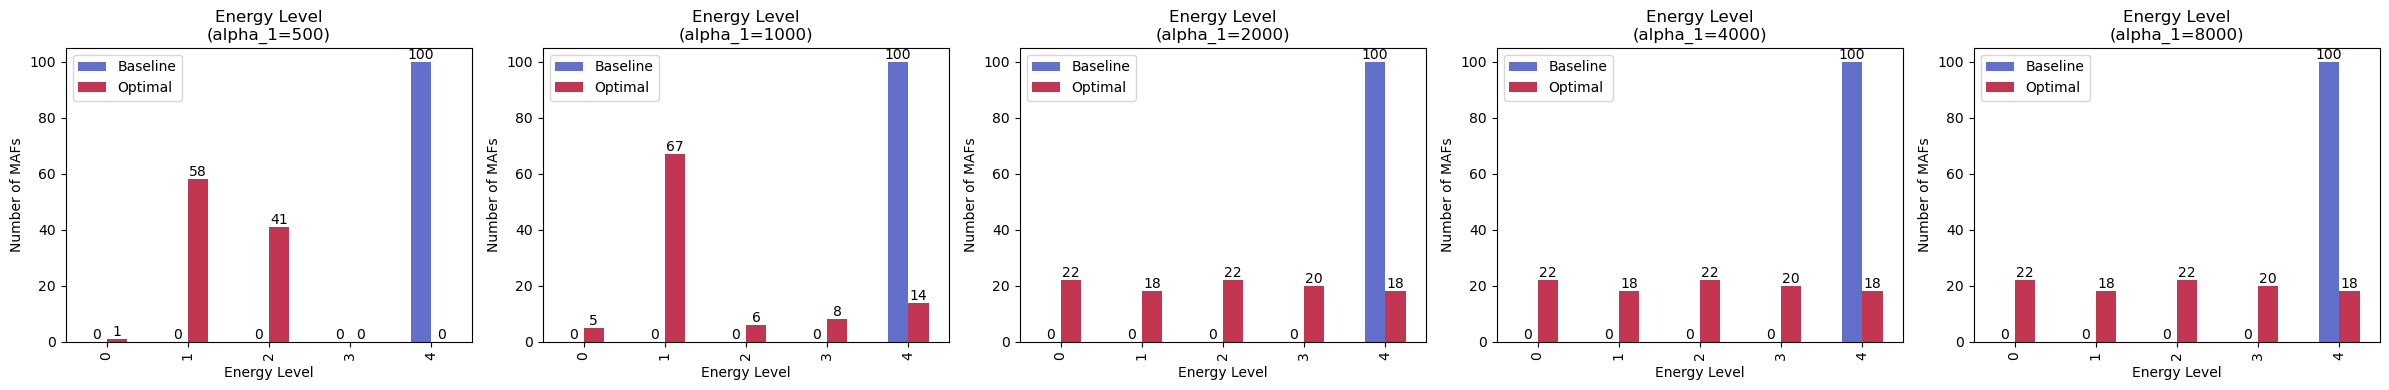

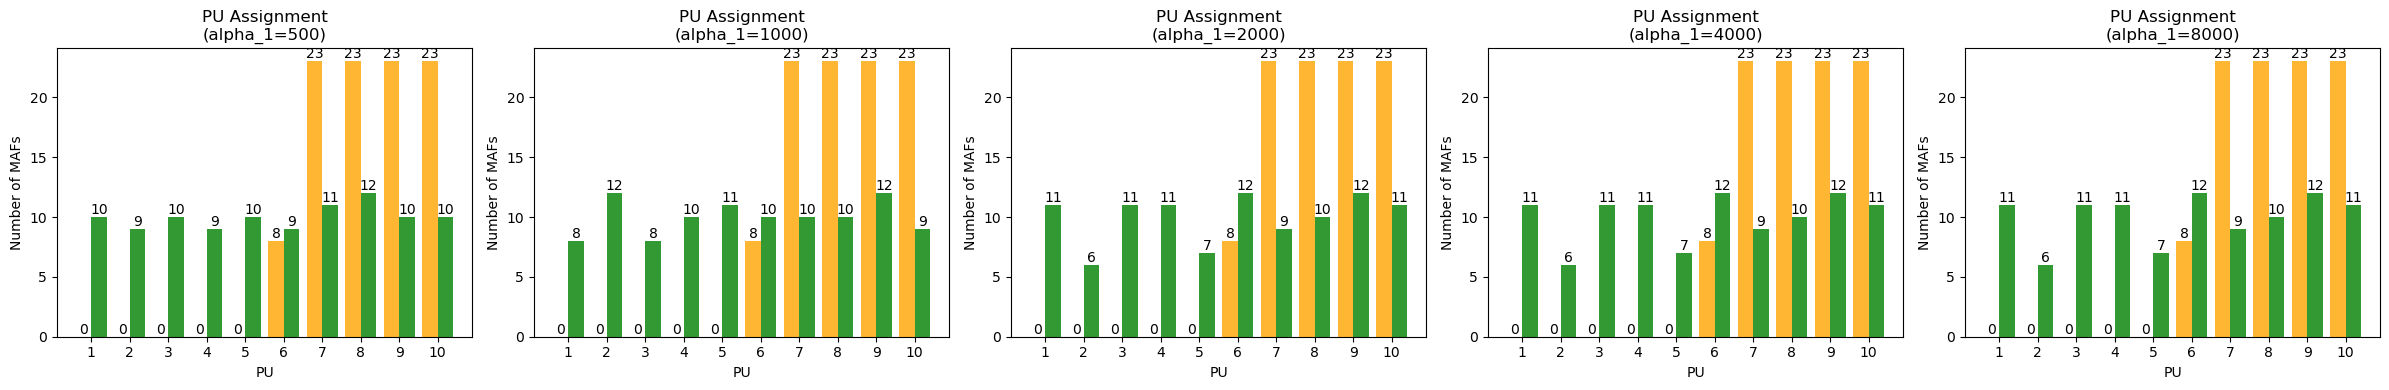

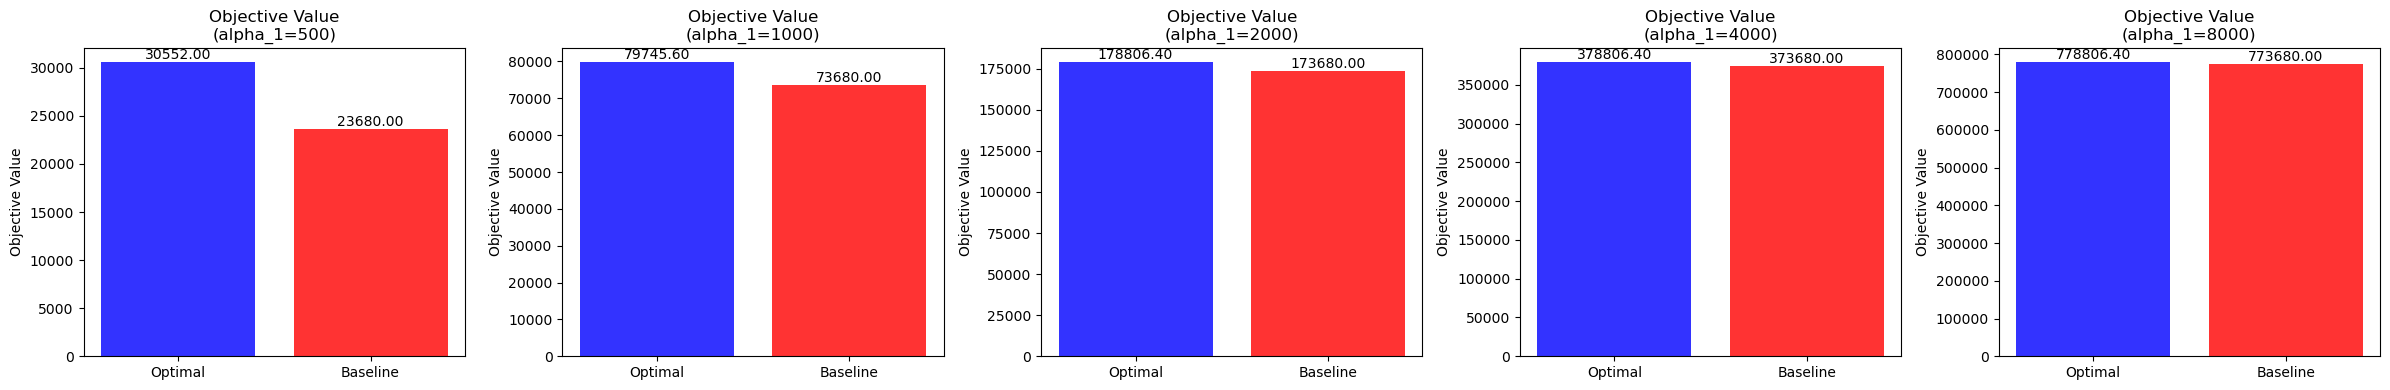

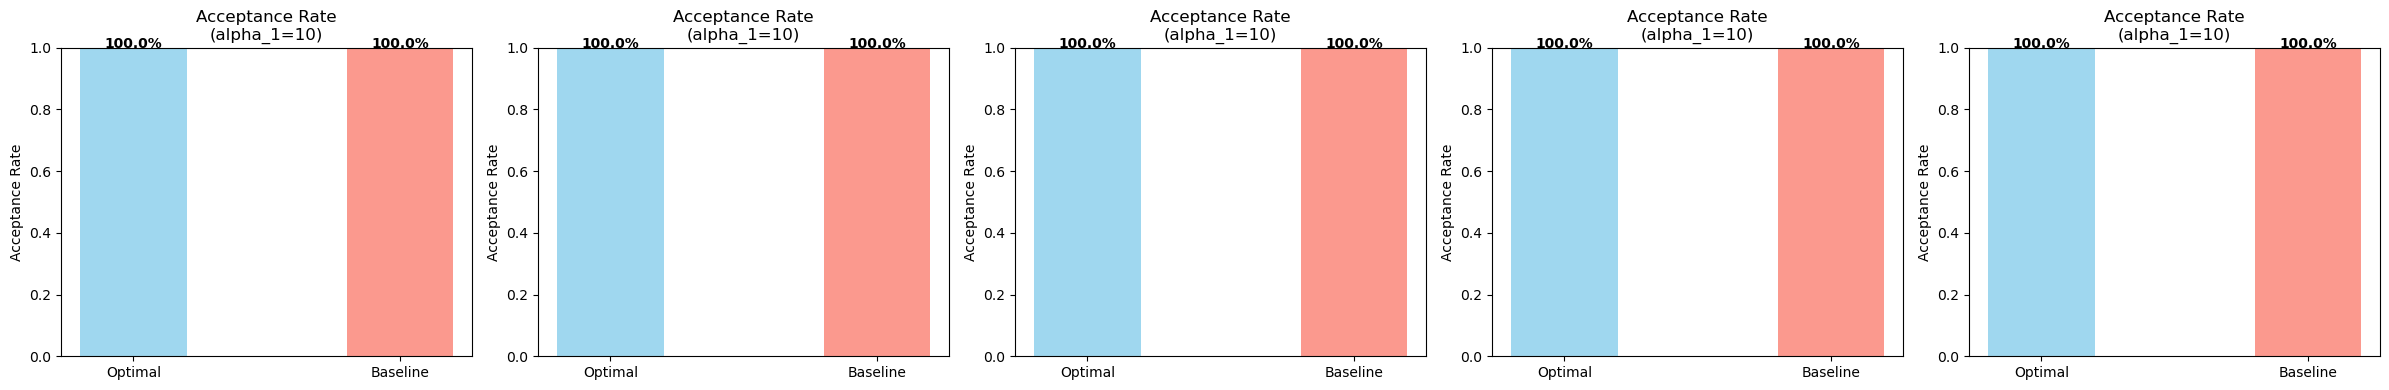

In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 10  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [1000] * m  # Maximum energy consumption per processing unit
CPU_capacity = [1500] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 10000  # Total system resource capacity
P_idle = [2] * m  # Idle power consumption per PU
T_total = 300  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption
# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [150] * num_chains 


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")

    for k in range(num_chains):
        chain = chain_tasks[k]
        
        # Task chain `k` failure logic: if any `delta[i] = 0` within `chain_tasks[k]`, then `z_chain_k[k] = 0`.
        for i in chain:
            model.addConstr(z_chain_k[k] <= delta[i], name=f"ChainActivation_{k}_Task_{i}")

        #  Calculation of end-to-end delay in the task chain (execution time + communication delay)
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) for i in chain)
        communication_delay =  len(chain) - 1  

        #  End-to-end (E2E) delay constraints (effective only if `z_chain_k[k] = 1`)
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # mafs constraints
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i])

    # Limiting PU resources (corrected version)
    for j in range(m):
        execution_time = quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        idle_time = T_total - execution_time  
        model.addConstr(U_j[j] == execution_time / T_total)
        model.addConstr(E_PU[j] == P_idle[j]*idle_time + (P_max[j]-P_idle[j])*U_j[j]*T_total)
        model.addConstr(E_PU[j] <= E_PU_max[j])


    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    # Baseline only modifies the energy level selection logic, other constraints are consistent with Optimal.
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    return model if model.status == GRB.OPTIMAL else None


# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  
       
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  
    
    return maf_energy_levels, maf_pu_assignments


optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)



# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 

alpha_2 = 4
alpha_PU = 1
alpha_1_list = [500, 1000, 2000, 4000, 8000]

test_param_list = alpha_1_list
test_param_name = "alpha_1"

results = []

fig_time, axes_time = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_energy, axes_energy = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_pu, axes_pu = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_obj, axes_obj = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_accept, axes_accept = plt.subplots(1, len(test_param_list), figsize=(24, 4))

for idx, alpha_1 in enumerate(test_param_list):

    # 运行 Optimal 模型
    start_time_opt = time.perf_counter()
    optimal_model = run_gurobi_model(alpha_1, alpha_2, alpha_PU, baseline=False)
    execution_time_opt = time.perf_counter() - start_time_opt

    # 运行 Baseline 模型
    start_time_base = time.perf_counter()
    baseline_model = run_gurobi_model(alpha_1, alpha_2, alpha_PU, baseline=True)
    execution_time_base = time.perf_counter() - start_time_base

    optimal_obj = optimal_model.objVal if optimal_model else None
    baseline_obj = baseline_model.objVal if baseline_model else None

    acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
    acceptance_rate_base = calculate_acceptance_rate(baseline_model)

    optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
    baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

    results.append({
        test_param_name: alpha_1,
        'Optimal_Obj': optimal_obj,
        'Baseline_Obj': baseline_obj,
        'Optimal_Time': execution_time_opt,
        'Baseline_Time': execution_time_base,
        'Optimal_Acceptance': acceptance_rate_opt,
        'Baseline_Acceptance': acceptance_rate_base,
    })

    # === 执行时间可视化 ===
    axes_time[idx].bar(["Optimal", "Baseline"], [execution_time_opt, execution_time_base],
                       color=["green", "orange"], alpha=0.8)
    axes_time[idx].set_title(f"Execution Time\n({test_param_name}={alpha_1})")
    axes_time[idx].set_ylabel('Time (seconds)')
    axes_time[idx].bar_label(axes_time[idx].containers[0], fmt='%.2fs')

    # === 能耗等级分布可视化 ===
    df_energy = pd.DataFrame({
        "Baseline": np.bincount(baseline_energy_levels, minlength=K + 1)[1:],
        "Optimal": np.bincount(optimal_energy_levels, minlength=K + 1)[1:]
    })
    df_energy.plot(kind="bar", ax=axes_energy[idx], colormap="coolwarm", alpha=0.8)
    axes_energy[idx].set_title(f"Energy Level\n({test_param_name}={alpha_1})")
    axes_energy[idx].set_xlabel("Energy Level")
    axes_energy[idx].set_ylabel("Number of MAFs")
    for container in axes_energy[idx].containers:
        axes_energy[idx].bar_label(container)

    # === PU任务分配可视化 ===
    df_pu = pd.DataFrame({
        "Baseline": np.bincount(baseline_pu_assignments, minlength=m + 1)[1:].astype(int),
        "Optimal": np.bincount(optimal_pu_assignments, minlength=m + 1)[1:].astype(int)
    })
    bar_width = 0.4
    x = np.arange(1, m + 1)
    bars_baseline = axes_pu[idx].bar(x - bar_width/2, df_pu["Baseline"], width=bar_width, color="orange", alpha=0.8)
    bars_optimal = axes_pu[idx].bar(x + bar_width/2, df_pu["Optimal"], width=bar_width, color="green", alpha=0.8)
    axes_pu[idx].set_title(f"PU Assignment\n({test_param_name}={alpha_1})")
    axes_pu[idx].set_xlabel("PU")
    axes_pu[idx].set_ylabel("Number of MAFs")
    axes_pu[idx].set_xticks(np.arange(1, m + 1))
    axes_pu[idx].bar_label(bars_baseline)
    axes_pu[idx].bar_label(bars_optimal)

    # === 目标函数对比可视化 ===
    bars_obj = axes_obj[idx].bar(["Optimal", "Baseline"], [optimal_obj, baseline_obj], color=["blue", "red"], alpha=0.8)
    axes_obj[idx].set_title(f"Objective Value\n({test_param_name}={alpha_1})")
    axes_obj[idx].set_ylabel("Objective Value")
    axes_obj[idx].bar_label(bars_obj, fmt='%.2f')

    # === Acceptance Rate ===
    axes_accept[idx].bar(["Optimal", "Baseline"], [acceptance_rate_opt, acceptance_rate_base], color=["skyblue", "salmon"], alpha=0.8, width=0.4)
    axes_accept[idx].set_ylim(0, 1)
    axes_accept[idx].set_title(f"Acceptance Rate\n({test_param_name}={num_chains})")
    axes_accept[idx].set_ylabel("Acceptance Rate")
    for i, v in enumerate([acceptance_rate_opt, acceptance_rate_base]):
        axes_accept[idx].text(i, v, f"{v:.1%}", ha='center', fontsize=10, fontweight='bold')

# 调整布局
fig_time.tight_layout()
fig_energy.tight_layout()
fig_pu.tight_layout()
fig_obj.tight_layout()
fig_accept.tight_layout()

plt.show()
